# Importacion de las librerias

In [1]:
# Manejo de datos
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import utils
from sklearn.model_selection import KFold, cross_val_score

# Ploting
import matplotlib.pyplot as plt
import colour

# Redes Neuronales
import tensorflow as tf
from tensorflow import keras
import scikeras

# Scikit learn
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import (LinearRegression, Ridge, Lasso, ElasticNet,
                                 BayesianRidge)
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor, 
                              AdaBoostRegressor)
from xgboost import XGBRegressor

# Implementacion de tensorboard
# Load the TensorBoard notebook extension
# %load_ext tensorboard
import datetime
import optuna
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score)

from time import perf_counter
# from PIL import Image

# Lectura y procesamiento del Dataset

In [2]:
df = pd.read_csv('df_rgb_xyz.csv').drop('Unnamed: 0',axis=1)
df['R'] = df['R'] / 100
df['DEE'] = df['DEE'] / 80
df_test = df
df = df.drop(['z'], axis=1)
print(df.shape)
df.head()

(24635, 8)


,R,DEE,Remb,r,g,b,x,y
0,0.101691,0.891269,0.5481,0.607739,0.607748,0.610636,0.312052,0.327911
1,0.249168,0.539952,0.3979,0.614463,0.662313,0.545797,0.326839,0.373410
2,0.914374,0.211320,0.6341,0.643678,0.632023,0.563976,0.331315,0.354632
3,0.859463,0.568773,0.8010,0.667089,0.649641,0.526636,0.344984,0.374364
4,0.311980,0.182830,0.3469,0.752189,0.582688,0.540596,0.369491,0.343779


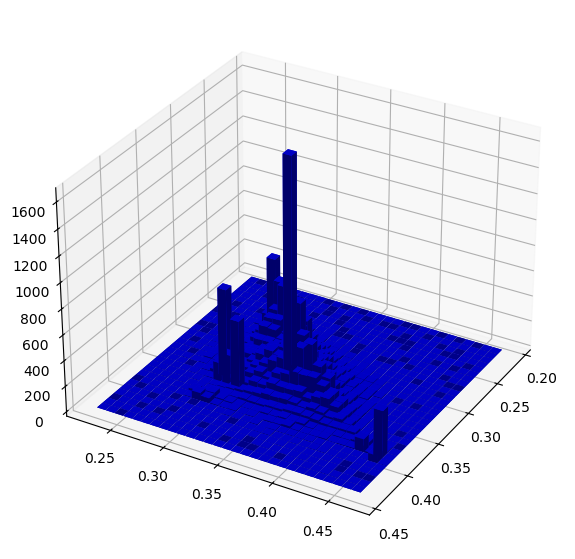

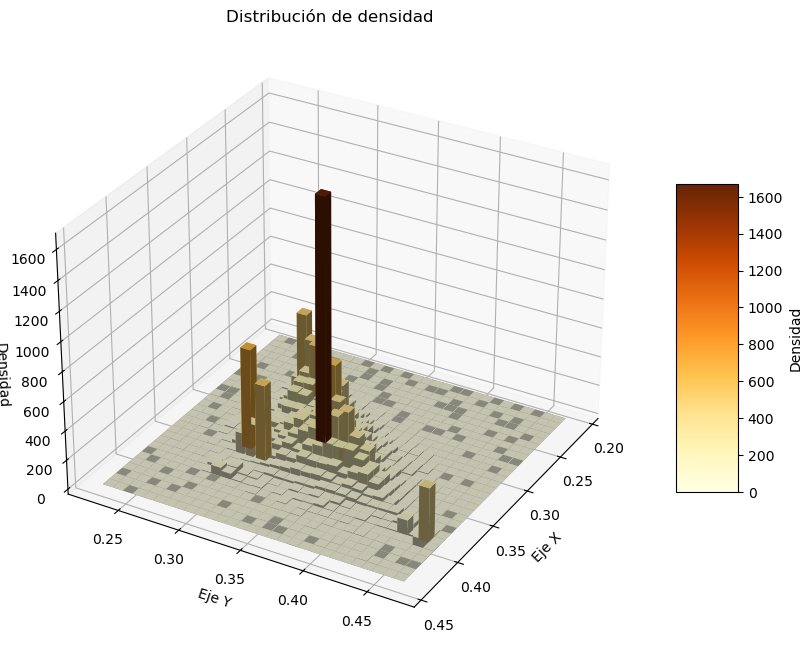

In [39]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde


# Supongamos que tienes las siguientes listas o arrays para x e y:
x = df['x']
y = df['y']

# Calcula los puntos de densidad de KDE
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

# Creamos una malla regular para evaluar la función de KDE
xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
zz = gaussian_kde(xy)(np.vstack([xx.flatten(), yy.flatten()]))
zz = zz.reshape(xx.shape)

# Crea la figura y el eje 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Configura los límites para los bins
x_bins = np.linspace(x.min(), x.max(), 30)
y_bins = np.linspace(y.min(), y.max(), 30)

# Calcula el histograma 2D
histogram, xedges, yedges = np.histogram2d(x, y, bins=(x_bins, y_bins))

# Posiciones de las barras
xpos, ypos = np.meshgrid(xedges[:-1] + np.diff(xedges)/2, yedges[:-1] + np.diff(yedges)/2)
xpos = xpos.flatten('F')
ypos = ypos.flatten('F')
zpos = np.zeros_like(xpos)

# Altura de las barras
dz = histogram.flatten()

# Tamaño de las barras
dx = dy = np.ones_like(dz) * (xedges[1] - xedges[0])

# Graficar las barras
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='b', zsort='average')

# Ajustar la vista
ax.view_init(elev=30, azim=30)
#=============================================================================================
# Altura de las barras
dz = histogram.flatten()

# Tamaño de las barras
dx = dy = np.ones_like(dz) * (xedges[1] - xedges[0])

# Creamos la figura y el eje 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Para cambiar el color de las barras basado en la densidad, normalizamos 'dz' y creamos un mapa de colores
norm = Normalize(dz.min(), dz.max())
colors = plt.cm.YlOrBr(norm(dz))

# Graficamos las barras con los colores basados en la densidad
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=colors, zsort='average')

# Ajustamos la vista
ax.view_init(elev=30, azim=30)

# Creamos el mappable para la barra de color
mappable = ScalarMappable(norm=norm, cmap='YlOrBr')
mappable.set_array(dz)

# Barra de color para la densidad
color_bar = plt.colorbar(mappable, shrink=0.5, aspect=5, ax=ax)
color_bar.set_label('Densidad')

# Etiquetas de los ejes y título
ax.set_title('Distribución de densidad')
ax.set_xlabel('Eje X')
ax.set_ylabel('Eje Y')
ax.set_zlabel('Densidad')

plt.show()

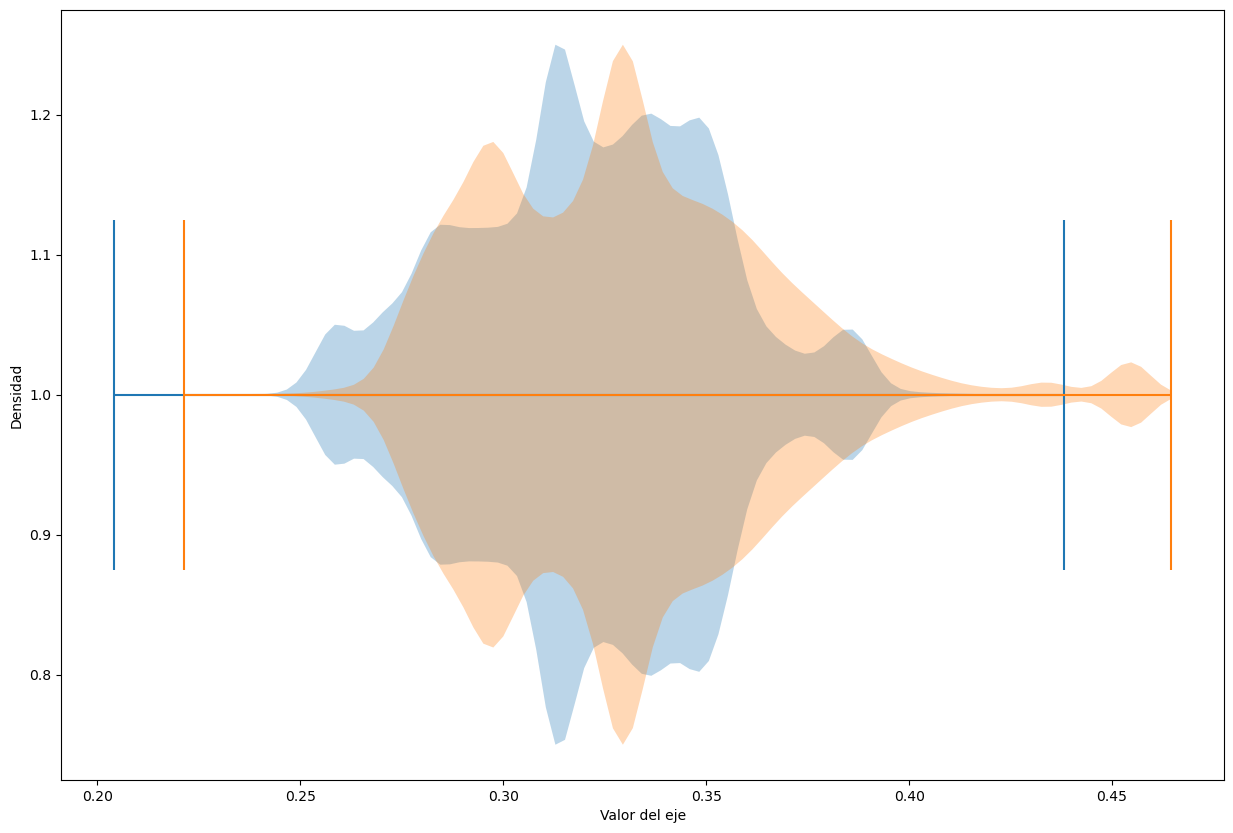

In [41]:
plt.figure(figsize=(15,10))
plt.violinplot(df['x'],vert=False)
plt.violinplot(df['y'],vert=False)
plt.ylabel('Densidad')
plt.xlabel('Valor del eje')
plt.show()

In [4]:
numero_duplicados = df.duplicated().sum()

if numero_duplicados > 0:
    print(f"Hay {numero_duplicados} filas duplicadas en el DataFrame.")
else:
    print("No hay filas duplicadas en el DataFrame.")

Hay 56 filas duplicadas en el DataFrame.


In [5]:
df.drop_duplicates(inplace=True)

In [6]:
df = df.drop(df[df['r']==df.r.min()].index[0],axis=0)
df = df.drop(df[df['r']==df.r.min()].index[0],axis=0)
# plt.violinplot(df.r,vert=False)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
R,24577.0,0.565412,0.283819,0.050000,0.345268,0.560028,0.803974,1.000000
DEE,24577.0,0.474418,0.276595,0.062500,0.233655,0.481486,0.673951,1.000000
Remb,24577.0,0.658336,0.188132,0.300000,0.520000,0.690630,0.775500,1.000000
r,24577.0,0.627953,0.080788,0.237164,0.574827,0.630769,0.685175,0.880922
g,24577.0,0.601178,0.049325,0.363591,0.575097,0.607423,0.629796,0.740896
b,24577.0,0.595540,0.063179,0.280018,0.566041,0.606228,0.632765,0.756195
x,24577.0,0.321548,0.030298,0.238820,0.300626,0.321979,0.343672,0.438084
y,24577.0,0.330573,0.036489,0.221430,0.301340,0.328957,0.351359,0.464530


# Creacion de los datos de entrenamiento de manera aleatoria

In [7]:
import random
random.seed(a=17)
test = [(random.random(), random.random(), random.random()) for i in range(1000)]
print(len(test))
test = pd.DataFrame(test)
test.columns=['r','g','b']
test

1000


,r,g,b
0,0.521984,0.806691,0.960495
1,0.289625,0.766107,0.704220
2,0.661383,0.110162,0.026937
3,0.384171,0.746395,0.252384
4,0.501603,0.317435,0.846328
...,...,...,...
995,0.400034,0.083313,0.181476
996,0.693631,0.914663,0.280728
997,0.049622,0.380955,0.980771
998,0.075694,0.143321,0.941641


In [8]:
knn = KNeighborsRegressor(n_neighbors=1)
knn.fit(df.drop(['R', 'DEE', 'Remb','x','y'],axis=1), df[['R', 'DEE', 'Remb']])

# Prediciendo nuevos datos
predictions = knn.predict(test)
test = pd.DataFrame(predictions)
test.columns=('R','DEE','Remb')
test

,R,DEE,Remb
0,0.734497,0.638300,0.456900
1,0.645693,0.569124,0.357100
2,0.775672,0.532375,0.871967
3,0.402796,0.438091,0.522500
4,0.919255,0.896736,0.705899
...,...,...,...
995,0.357678,0.623024,0.300000
996,0.396797,0.449454,0.603000
997,0.842175,0.256820,0.795555
998,0.919255,0.896736,0.705899


In [9]:
test = pd.merge(test, df[['r', 'g', 'b', 'R', 'DEE', 'Remb','x','y']], 
                  on=['R', 'Remb', 'DEE'], 
                  how='left')
test.head()
x_test = test.drop(['R', 'DEE', 'Remb','x','y'],axis=1)
y_test = test[['R', 'DEE', 'Remb']]
test.head()
x_test.shape,y_test.shape

((1000, 3), (1000, 3))

In [11]:
# Unir df1 con df2 usando un 'inner' merge
merged_df = test.merge(df, how='inner')

# Verificar si todas las filas de df1 están en df2
all_rows_present = len(merged_df) == len(test)
all_rows_present

True

# Sustracion de los datos de entramiento del df original

In [12]:
# Concatenar df1 y df2
concatenated = pd.concat([test, df])

# Eliminar duplicados, manteniendo la primera ocurrencia (es decir, las filas de df1)
concatenated_unique = concatenated.drop_duplicates(keep='first')

# Eliminar las filas que estaban en df1 para obtener el df2 limpio
df = concatenated_unique[~concatenated_unique.index.isin(test.index)]
df.shape

(23378, 8)

In [13]:
df.shape, test.shape

((23378, 8), (1000, 8))

In [14]:
# combined_df = pd.concat([test, df])
# filtered_df = combined_df.drop_duplicates(subset=test.columns.tolist(), keep='last')

# Conserva solo las filas que originalmente estaban en df
# df = filtered_df.iloc[len(test):]
x_df = df.drop(['R', 'DEE', 'Remb','x','y'],axis=1)
y_df = df[['R', 'DEE', 'Remb']] 

In [15]:
x_df.shape, y_df.shape

((23378, 3), (23378, 3))

# Ubicacion de las muestras en el espacio de color CIIE 1931

C:\Users\Private Richi\anaconda3\envs\DL\lib\site-packages\colour\utilities\verbose.py:262: ColourUsageWarning: The "CIE 2012 2 Degree Standard Observer" has been renamed to "CIE 2015 2 Degree Standard Observer" for consistency with the official CIE name which was adopted in 2015.
  warn(*args, **kwargs)  # noqa: B028
C:\Users\Private Richi\anaconda3\envs\DL\lib\site-packages\colour\utilities\verbose.py:262: ColourUsageWarning: The "CIE 2012 10 Degree Standard Observer" has been renamed to "CIE 2015 10 Degree Standard Observer" for consistency with the official CIE name which was adopted in 2015.
  warn(*args, **kwargs)  # noqa: B028
C:\Users\Private Richi\anaconda3\envs\DL\lib\site-packages\colour\utilities\verbose.py:262: ColourUsageWarning: "standalone" argument has been renamed to "show".
  warn(*args, **kwargs)  # noqa: B028
C:\Users\Private Richi\anaconda3\envs\DL\lib\site-packages\colour\utilities\verbose.py:262: ColourUsageWarning: "standalone" argument has been renamed to "sho

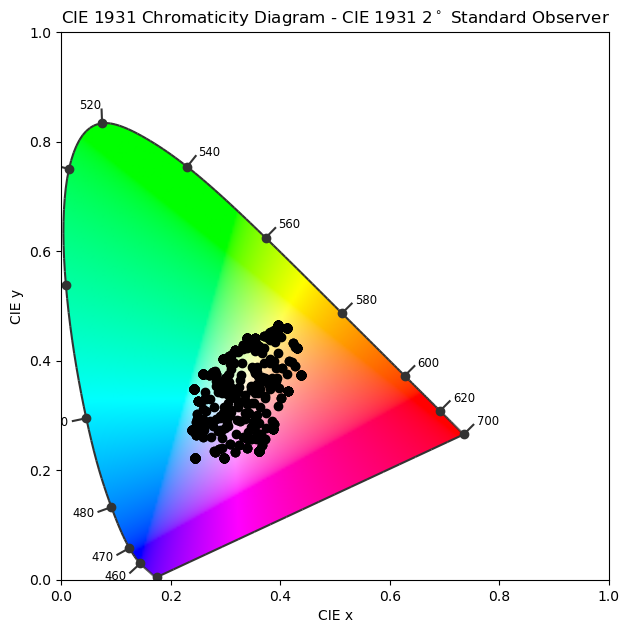

In [16]:
import colour
df_test = pd.merge(test, df_test[['R', 'DEE', 'Remb']], 
                  on=['R', 'Remb', 'DEE'], 
                  how='left')
test.head()

# Define your scatter plot points (CIE xy coordinates)
x = df_test['x']
y = df_test['y']

# Plot the CIE 1931 Chromaticity Diagram
colour.plotting.plot_chromaticity_diagram_CIE1931(standalone=False)

# Scatter plot of your points
plt.scatter(x, y, c='black')
# Show the plot
plt.show()

In [27]:
x2_df = df[['x', 'y']]
y2_df = df[['R','DEE','Remb']]
x2_test = df_test[['x', 'y']]
y2_test = df_test[['R','DEE','Remb']]

# Entrenamiento de los modelos

In [20]:
# Creación de listas para el guardado de los resultados de cada entrenamiento
Model = []
NMSE = []
NMAE = []
cv = KFold(10)

# Guardado de los resultados del entrenamiento del algoritmo 
def input_scores(name, model, x, y):
    Model.append(name)
    NMSE.append(cross_val_score(model, x, y, cv=cv, scoring='neg_mean_squared_error').mean())
    NMAE.append(cross_val_score(model, x, y, cv=cv, scoring='neg_mean_absolute_error').mean())

names = ['Linear Regression', 'Lasso Regression', 
         'ElasticNet Regression', 'SVR', 'Gaussian Regressor', 'Bayesian Ridge',
         'K Neighbors Regressor', 'Decision Tree Regressor', 
         'Random Forest Regressor', 'Gradient Boosting Regressor',
         'Adaboost Regressor','XGBoost']

models = [LinearRegression(), Lasso(), ElasticNet(),
          SVR(), GaussianProcessRegressor(), BayesianRidge(),
          KNeighborsRegressor(), 
          DecisionTreeRegressor(),
          RandomForestRegressor(), GradientBoostingRegressor(), 
          AdaBoostRegressor(), XGBRegressor()]

# Entrenamiento de cada modelo de la lista "models" a lo fuerza bruta
for name, model in zip(names, models):
    wrapped_model = MultiOutputRegressor(model)
    input_scores(name, wrapped_model, x_df, y_df)

# Creación de un dataframe a partir de la información recolectada
evaluation = pd.DataFrame({'Model': Model,
                           'MSE' : NMSE})
evaluation

,Model,MSE
0,Linear Regression,-0.072969
1,Lasso Regression,-0.068690
2,ElasticNet Regression,-0.068690
3,SVR,-0.058347
4,Gaussian Regressor,-0.064954
5,Bayesian Ridge,-0.072919
6,K Neighbors Regressor,-0.056257
7,Decision Tree Regressor,-0.090958
8,Random Forest Regressor,-0.055860
9,Gradient Boosting Regressor,-0.051172


## KNNR Multivariable

In [45]:
def objective(trial):
    
    # Definición de hiperparámetros a optimizar
    n_neighbors = trial.suggest_int('n_neighbors', 2, 40)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    metric = trial.suggest_categorical('metric', ['minkowski', 'euclidean', 'manhattan', 'chebyshev'])
    p = 2 if metric != 'minkowski' else trial.suggest_int('p', 1, 5)  # 'p' sólo es relevante para la métrica 'minkowski'
    metric_params = None if metric != 'wminkowski' else {'w': trial.suggest_float('w', 0.0, 1.0)}  # 'w' sólo es relevante para 'wminkowski'
    
    # Creación del modelo con los hiperparámetros sugeridos
    model_knn = KNeighborsRegressor(
        n_neighbors=n_neighbors,
        weights=weights,
        metric=metric,
        p=p,
        metric_params=metric_params
    )
    
    # Se utiliza la validación cruzada para evaluar el rendimiento del modelo
    return cross_val_score(model_knn,x_df, y_df, n_jobs=-1, cv=10, scoring='neg_mean_absolute_error').mean()

# Crear un estudio de Optuna y optimizar el estudio
study = optuna.create_study(direction='maximize')  # Maximizar porque estamos usando 'neg_mean_squared_error'
study.optimize(objective, n_trials=100)

# Resultados de la optimización
print(f"Valor óptimo de neg_mean_squared_error: {study.best_value}")
print(f"Mejores hiperparámetros: {study.best_params}")


[I 2023-11-06 08:50:53,638] A new study created in memory with name: no-name-c641f2b7-2f9e-4463-aa44-0980254c9b3f
[I 2023-11-06 08:50:55,663] Trial 0 finished with value: -0.17651079214962387 and parameters: {'n_neighbors': 39, 'weights': 'distance', 'metric': 'chebyshev'}. Best is trial 0 with value: -0.17651079214962387.
[I 2023-11-06 08:50:56,799] Trial 1 finished with value: -0.17689875395625007 and parameters: {'n_neighbors': 29, 'weights': 'distance', 'metric': 'chebyshev'}. Best is trial 0 with value: -0.17651079214962387.
[I 2023-11-06 08:50:57,913] Trial 2 finished with value: -0.17715293972439178 and parameters: {'n_neighbors': 21, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 0 with value: -0.17651079214962387.
[I 2023-11-06 08:50:58,804] Trial 3 finished with value: -0.17667443670098226 and parameters: {'n_neighbors': 30, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 0 with value: -0.17651079214962387.
[I 2023-11-06 08:50:58,867] Trial 4 finishe

[I 2023-11-06 08:51:01,343] Trial 39 finished with value: -0.1932665832477221 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'minkowski', 'p': 5}. Best is trial 8 with value: -0.17633993586100855.
[I 2023-11-06 08:51:01,415] Trial 40 finished with value: -0.17641430123082608 and parameters: {'n_neighbors': 38, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 8 with value: -0.17633993586100855.
[I 2023-11-06 08:51:01,489] Trial 41 finished with value: -0.17633993586100855 and parameters: {'n_neighbors': 40, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 8 with value: -0.17633993586100855.
[I 2023-11-06 08:51:01,562] Trial 42 finished with value: -0.1764110966382111 and parameters: {'n_neighbors': 39, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 8 with value: -0.17633993586100855.
[I 2023-11-06 08:51:01,646] Trial 43 finished with value: -0.17649549184144545 and parameters: {'n_neighbors': 36, 'weights': 'distance', 'metric':

[I 2023-11-06 08:51:04,218] Trial 78 finished with value: -0.17632011818547227 and parameters: {'n_neighbors': 37, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 44 with value: -0.17609216667804514.
[I 2023-11-06 08:51:04,288] Trial 79 finished with value: -0.1764302078579253 and parameters: {'n_neighbors': 35, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 44 with value: -0.17609216667804514.
[I 2023-11-06 08:51:04,358] Trial 80 finished with value: -0.1766209267655941 and parameters: {'n_neighbors': 32, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 44 with value: -0.17609216667804514.
[I 2023-11-06 08:51:04,429] Trial 81 finished with value: -0.17632011818547227 and parameters: {'n_neighbors': 37, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 44 with value: -0.17609216667804514.
[I 2023-11-06 08:51:04,500] Trial 82 finished with value: -0.17649834841160242 and parameters: {'n_neighbors': 34, 'weights': 'distance', 'metric': 'm

Valor óptimo de neg_mean_squared_error: -0.17609216667804514
Mejores hiperparámetros: {'n_neighbors': 40, 'weights': 'distance', 'metric': 'manhattan'}


In [46]:
knn_m = KNeighborsRegressor(n_neighbors=40, weights='distance', metric='manhattan',)
knn_m.fit(x_df , y_df)


KNeighborsRegressor(metric='manhattan', n_neighbors=40, weights='distance')

In [79]:
knn_pred = knn_m.predict(x_test)
mse_knn = mean_squared_error(y_test, knn_pred)
print(mse_knn)

0.0566591645384


## Gradient Boosting

In [67]:
#Busqueda de hiperparametros para GradientBooost
def objective_gbr(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 2, 8)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 8)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 8)
    model =  MultiOutputRegressor(GradientBoostingRegressor(
        n_estimators=n_estimators, 
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf
    ))
    model.fit(x_df, y_df)
    y_pred = model.predict(x_test)
    return mean_squared_error(y_test, y_pred)

study_gbr = optuna.create_study(direction='minimize')
study_gbr.optimize(objective_gbr, n_trials=100)

[I 2023-11-06 09:08:21,996] A new study created in memory with name: no-name-b8c68f32-4859-4ad5-ad90-82c7f622af0d
[I 2023-11-06 09:08:44,220] Trial 0 finished with value: 0.052515332833364965 and parameters: {'n_estimators': 216, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.052515332833364965.
[I 2023-11-06 09:09:49,922] Trial 1 finished with value: 0.06363323696564505 and parameters: {'n_estimators': 216, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.052515332833364965.
[I 2023-11-06 09:10:30,994] Trial 2 finished with value: 0.06453676652610153 and parameters: {'n_estimators': 136, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.052515332833364965.
[I 2023-11-06 09:11:50,293] Trial 3 finished with value: 0.0683351694194652 and parameters: {'n_estimators': 197, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 7}. Best is trial 0 with

[I 2023-11-06 09:25:00,945] Trial 36 finished with value: 0.05593468558555855 and parameters: {'n_estimators': 67, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 35 with value: 0.04732734208210276.
[I 2023-11-06 09:25:26,466] Trial 37 finished with value: 0.058303125769004295 and parameters: {'n_estimators': 125, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 35 with value: 0.04732734208210276.
[I 2023-11-06 09:26:05,114] Trial 38 finished with value: 0.06535003873420865 and parameters: {'n_estimators': 152, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 7}. Best is trial 35 with value: 0.04732734208210276.
[I 2023-11-06 09:26:31,675] Trial 39 finished with value: 0.05609625895301037 and parameters: {'n_estimators': 173, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 35 with value: 0.04732734208210276.
[I 2023-11-06 09:26:52,652] Trial 40 finished with value: 0.05138917680320293 an

[I 2023-11-06 09:32:07,264] Trial 72 finished with value: 0.04630293066615449 and parameters: {'n_estimators': 56, 'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 71 with value: 0.045810778326513445.
[I 2023-11-06 09:32:13,070] Trial 73 finished with value: 0.046302930666154506 and parameters: {'n_estimators': 56, 'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 71 with value: 0.045810778326513445.
[I 2023-11-06 09:32:18,968] Trial 74 finished with value: 0.046207108061812774 and parameters: {'n_estimators': 57, 'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 71 with value: 0.045810778326513445.
[I 2023-11-06 09:32:26,804] Trial 75 finished with value: 0.05211933421122807 and parameters: {'n_estimators': 51, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 71 with value: 0.045810778326513445.
[I 2023-11-06 09:32:51,527] Trial 76 finished with value: 0.05237456892555876 

In [75]:
model_gbr = MultiOutputRegressor(GradientBoostingRegressor(n_estimators = 65,
                                                       max_depth = 2,
                                                       min_samples_split = 5,
                                                       min_samples_leaf = 7))
model_gbr.fit(x_df, y_df)

y_pred_gbr = model_gbr.predict(x_test)

mse_gbr = mean_squared_error(y_test, y_pred_gbr)
mse_gbr

0.045655785422287674

## XGBoost

In [43]:
def objective_xgb(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 2, 8)
    gamma = trial.suggest_float('gamma', 0.0, 0.5, step=0.1)
    model =  MultiOutputRegressor(XGBRegressor(
        n_estimators=n_estimators, 
        max_depth=max_depth,
        gamma=gamma
    ))
    model.fit(x_df, y_df)
    y_pred = model.predict(x_test)
    return mean_squared_error(y_test, y_pred)

study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=100)

[I 2023-11-06 08:48:20,779] A new study created in memory with name: no-name-09e49e24-3152-4f97-8b09-63c3b7c87254
[I 2023-11-06 08:48:21,024] Trial 0 finished with value: 0.05378792107613322 and parameters: {'n_estimators': 224, 'max_depth': 6, 'gamma': 0.5}. Best is trial 0 with value: 0.05378792107613322.
[I 2023-11-06 08:48:21,176] Trial 1 finished with value: 0.057164962733397016 and parameters: {'n_estimators': 114, 'max_depth': 8, 'gamma': 0.5}. Best is trial 0 with value: 0.05378792107613322.
[I 2023-11-06 08:48:21,464] Trial 2 finished with value: 0.058195287061275726 and parameters: {'n_estimators': 259, 'max_depth': 6, 'gamma': 0.1}. Best is trial 0 with value: 0.05378792107613322.
[I 2023-11-06 08:48:21,757] Trial 3 finished with value: 0.057913601915384715 and parameters: {'n_estimators': 268, 'max_depth': 8, 'gamma': 0.4}. Best is trial 0 with value: 0.05378792107613322.
[I 2023-11-06 08:48:21,889] Trial 4 finished with value: 0.05433770159615662 and parameters: {'n_estima

[I 2023-11-06 08:48:29,916] Trial 41 finished with value: 0.047054787506811045 and parameters: {'n_estimators': 250, 'max_depth': 2, 'gamma': 0.4}. Best is trial 19 with value: 0.047054787506811045.
[I 2023-11-06 08:48:30,214] Trial 42 finished with value: 0.047054787506811045 and parameters: {'n_estimators': 265, 'max_depth': 2, 'gamma': 0.4}. Best is trial 19 with value: 0.047054787506811045.
[I 2023-11-06 08:48:30,531] Trial 43 finished with value: 0.057224898107797684 and parameters: {'n_estimators': 283, 'max_depth': 3, 'gamma': 0.5}. Best is trial 19 with value: 0.047054787506811045.
[I 2023-11-06 08:48:30,671] Trial 44 finished with value: 0.047054789691425215 and parameters: {'n_estimators': 87, 'max_depth': 2, 'gamma': 0.4}. Best is trial 19 with value: 0.047054787506811045.
[I 2023-11-06 08:48:30,928] Trial 45 finished with value: 0.052539323622002 and parameters: {'n_estimators': 208, 'max_depth': 6, 'gamma': 0.30000000000000004}. Best is trial 19 with value: 0.0470547875068

[I 2023-11-06 08:48:40,983] Trial 82 finished with value: 0.047054787506811045 and parameters: {'n_estimators': 213, 'max_depth': 2, 'gamma': 0.4}. Best is trial 19 with value: 0.047054787506811045.
[I 2023-11-06 08:48:41,259] Trial 83 finished with value: 0.047054787506811045 and parameters: {'n_estimators': 238, 'max_depth': 2, 'gamma': 0.4}. Best is trial 19 with value: 0.047054787506811045.
[I 2023-11-06 08:48:41,476] Trial 84 finished with value: 0.047054787506811045 and parameters: {'n_estimators': 166, 'max_depth': 2, 'gamma': 0.4}. Best is trial 19 with value: 0.047054787506811045.
[I 2023-11-06 08:48:41,790] Trial 85 finished with value: 0.057636289248645195 and parameters: {'n_estimators': 279, 'max_depth': 3, 'gamma': 0.4}. Best is trial 19 with value: 0.047054787506811045.
[I 2023-11-06 08:48:42,070] Trial 86 finished with value: 0.047054787506811045 and parameters: {'n_estimators': 243, 'max_depth': 2, 'gamma': 0.4}. Best is trial 19 with value: 0.047054787506811045.
[I 20

In [76]:
model_xgb = MultiOutputRegressor(XGBRegressor(n_estimators = 88,
                                             max_depth = 2,
                                             gamma = 0.4))
model_xgb.fit(x_df, y_df)

y_pred_xgb = model_xgb.predict(x_test)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mse_xgb

0.047054789654397612

In [80]:
models_scikit = pd.DataFrame({'Model': ['KNN', 'GBR', 'XGBR'],
                           'MSE' : [mse_knn, mse_gbr, mse_xgb]})
models_scikit

,Model,MSE
0,KNN,0.056659
1,GBR,0.045656
2,XGBR,0.047055


In [31]:
cie2rgb = keras.Sequential([
    keras.layers.Dense(512, input_shape = (2,), activation = 'relu'),
    keras.layers.Dense(256, activation = 'relu'),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dense(3)
])

cie2rgb.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.MeanSquaredError(),
    metrics = keras.metrics.MeanAbsolutePercentageError()
)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_percentage_error', patience=10, mode='min' ,restore_best_weights=True)

cie2rgb.fit(x2_df,  x_df, epochs=5000, validation_data=(x2_test, x_test), callbacks=[callback])

cie2rgb.evaluate(x2_test, x_test)

Epoch 1/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0059 - mean_absolute_percentage_error: 6.6659 - val_loss: 0.0017 - val_mean_absolute_percentage_error: 6.7264
Epoch 2/5000
731/731 [==============================] - 3s 5ms/step - loss: 3.0115e-05 - mean_absolute_percentage_error: 0.6690 - val_loss: 0.0013 - val_mean_absolute_percentage_error: 5.6969
Epoch 3/5000
731/731 [==============================] - 3s 5ms/step - loss: 1.7274e-05 - mean_absolute_percentage_error: 0.5140 - val_loss: 0.0011 - val_mean_absolute_percentage_error: 5.2170
Epoch 4/5000
731/731 [==============================] - 3s 4ms/step - loss: 1.4316e-05 - mean_absolute_percentage_error: 0.4835 - val_loss: 0.0011 - val_mean_absolute_percentage_error: 5.1104
Epoch 5/5000
731/731 [==============================] - 4s 5ms/step - loss: 1.1434e-05 - mean_absolute_percentage_error: 0.4370 - val_loss: 9.3850e-04 - val_mean_absolute_percentage_error: 4.6318
Epoch 6/5000
731/731 [==================

[0.0006342632696032524, 3.7099058628082275]

# TensorFlow

## Modelo de referencia

### CIE XY

In [33]:
model_ref_2_ins = keras.Sequential([
    keras.layers.Dense(950, input_shape = (2,), activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(3)
])

model_ref_2_ins.compile(
    optimizer=keras.optimizers.Adam(),
    loss = keras.losses.MeanSquaredError(),
    metrics = keras.metrics.MeanSquaredError()
)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=150, mode='min' ,restore_best_weights=True)

history_model_ref_2_ins = model_ref_2_ins.fit(x2_df,  y2_df, epochs=5000, validation_data=(x2_test, y2_test), callbacks=[callback])

model_ref_2_ins.evaluate(x2_test, y2_test)

Epoch 1/5000
731/731 [==============================] - 5s 6ms/step - loss: 0.0654 - mean_squared_error: 0.0654 - val_loss: 0.0715 - val_mean_squared_error: 0.0715
Epoch 2/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0577 - mean_squared_error: 0.0577 - val_loss: 0.0677 - val_mean_squared_error: 0.0677
Epoch 3/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0570 - mean_squared_error: 0.0570 - val_loss: 0.0676 - val_mean_squared_error: 0.0676
Epoch 4/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0551 - mean_squared_error: 0.0551 - val_loss: 0.0740 - val_mean_squared_error: 0.0740
Epoch 5/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0560 - mean_squared_error: 0.0560 - val_loss: 0.0778 - val_mean_squared_error: 0.0778
Epoch 6/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0547 - mean_squared_error: 0.0547 - val_loss: 0.0685 - val_mean_squared_error: 0.0685
Epoch 7/5000
731

Epoch 51/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0453 - mean_squared_error: 0.0453 - val_loss: 0.0425 - val_mean_squared_error: 0.0425
Epoch 52/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0455 - mean_squared_error: 0.0455 - val_loss: 0.0508 - val_mean_squared_error: 0.0508
Epoch 53/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0452 - mean_squared_error: 0.0452 - val_loss: 0.0545 - val_mean_squared_error: 0.0545
Epoch 54/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0456 - mean_squared_error: 0.0456 - val_loss: 0.0579 - val_mean_squared_error: 0.0579
Epoch 55/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0451 - mean_squared_error: 0.0451 - val_loss: 0.0607 - val_mean_squared_error: 0.0607
Epoch 56/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0454 - mean_squared_error: 0.0454 - val_loss: 0.0541 - val_mean_squared_error: 0.0541
Epoch 57/5

731/731 [==============================] - 4s 6ms/step - loss: 0.0438 - mean_squared_error: 0.0438 - val_loss: 0.0562 - val_mean_squared_error: 0.0562
Epoch 150/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0438 - mean_squared_error: 0.0438 - val_loss: 0.0600 - val_mean_squared_error: 0.0600
Epoch 151/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0438 - mean_squared_error: 0.0438 - val_loss: 0.0551 - val_mean_squared_error: 0.0551
Epoch 152/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0440 - mean_squared_error: 0.0440 - val_loss: 0.0546 - val_mean_squared_error: 0.0546
Epoch 153/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0438 - mean_squared_error: 0.0438 - val_loss: 0.0569 - val_mean_squared_error: 0.0569
Epoch 154/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0440 - mean_squared_error: 0.0440 - val_loss: 0.0549 - val_mean_squared_error: 0.0549
Epoch 155/5000
731/

[0.042460959404706955, 0.042460959404706955]

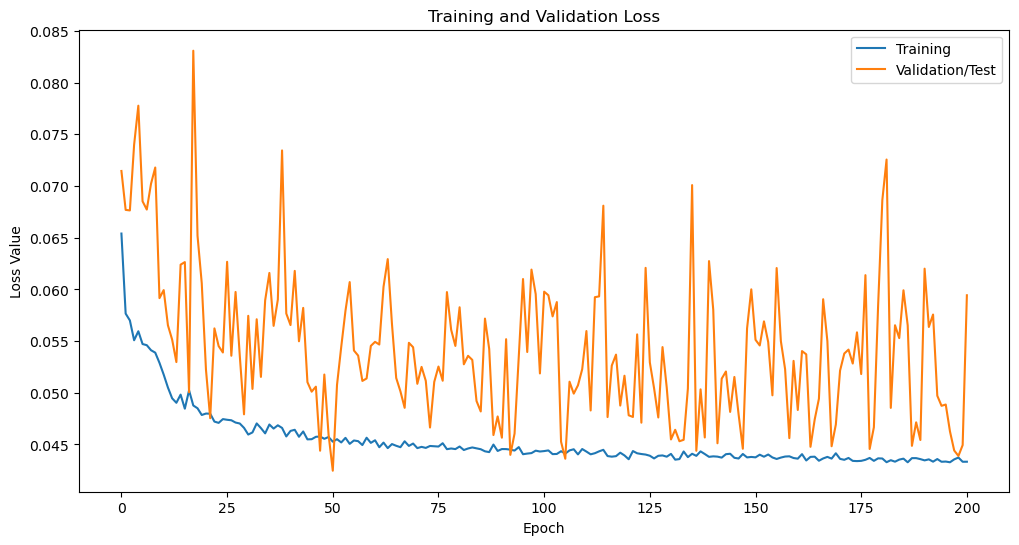

In [34]:
# Graficar el "training loss" y el "validation loss"
plt.figure(figsize=(12, 6))
plt.plot(history_model_ref_2_ins.history['mean_squared_error'], label='Training')
plt.plot(history_model_ref_2_ins.history['val_mean_squared_error'], label='Validation/Test')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

### sRGB

In [355]:
model_ref_3_ins = keras.Sequential([
    keras.layers.Dense(950, input_shape = (3,), activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(3)
])

model_ref_3_ins.compile(
    optimizer=keras.optimizers.Adam(),
    loss = keras.losses.MeanSquaredError(),
    metrics = keras.metrics.MeanSquaredError()
)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=150, mode='min' ,restore_best_weights=True)

history_model_ref_3_ins = model_ref_3_ins.fit(x_df,  y_df, epochs=5000, validation_data=(x_test, y_test), callbacks=[callback])

model_ref_3_ins.evaluate(x_test, y_test)

Epoch 1/5000
731/731 [==============================] - 8s 10ms/step - loss: 0.0624 - mean_squared_error: 0.0624 - val_loss: 0.0712 - val_mean_squared_error: 0.0712
Epoch 2/5000
731/731 [==============================] - 7s 9ms/step - loss: 0.0558 - mean_squared_error: 0.0558 - val_loss: 0.0930 - val_mean_squared_error: 0.0930
Epoch 3/5000
731/731 [==============================] - 5s 8ms/step - loss: 0.0549 - mean_squared_error: 0.0549 - val_loss: 0.0630 - val_mean_squared_error: 0.0630
Epoch 4/5000
731/731 [==============================] - 5s 7ms/step - loss: 0.0531 - mean_squared_error: 0.0531 - val_loss: 0.0789 - val_mean_squared_error: 0.0789
Epoch 5/5000
731/731 [==============================] - 6s 8ms/step - loss: 0.0522 - mean_squared_error: 0.0522 - val_loss: 0.0539 - val_mean_squared_error: 0.0539
Epoch 6/5000
731/731 [==============================] - 7s 9ms/step - loss: 0.0509 - mean_squared_error: 0.0509 - val_loss: 0.0599 - val_mean_squared_error: 0.0599
Epoch 7/5000
73

Epoch 51/5000
731/731 [==============================] - 5s 7ms/step - loss: 0.0442 - mean_squared_error: 0.0442 - val_loss: 0.0647 - val_mean_squared_error: 0.0647
Epoch 52/5000
731/731 [==============================] - 5s 7ms/step - loss: 0.0445 - mean_squared_error: 0.0445 - val_loss: 0.0734 - val_mean_squared_error: 0.0734
Epoch 53/5000
731/731 [==============================] - 5s 7ms/step - loss: 0.0444 - mean_squared_error: 0.0444 - val_loss: 0.0588 - val_mean_squared_error: 0.0588
Epoch 54/5000
731/731 [==============================] - 5s 7ms/step - loss: 0.0445 - mean_squared_error: 0.0445 - val_loss: 0.0526 - val_mean_squared_error: 0.0526
Epoch 55/5000
731/731 [==============================] - 5s 7ms/step - loss: 0.0444 - mean_squared_error: 0.0444 - val_loss: 0.0556 - val_mean_squared_error: 0.0556
Epoch 56/5000
731/731 [==============================] - 5s 7ms/step - loss: 0.0445 - mean_squared_error: 0.0445 - val_loss: 0.0685 - val_mean_squared_error: 0.0685
Epoch 57/5

731/731 [==============================] - 5s 7ms/step - loss: 0.0431 - mean_squared_error: 0.0431 - val_loss: 0.0567 - val_mean_squared_error: 0.0567
Epoch 150/5000
731/731 [==============================] - 5s 7ms/step - loss: 0.0430 - mean_squared_error: 0.0430 - val_loss: 0.0501 - val_mean_squared_error: 0.0501
Epoch 151/5000
731/731 [==============================] - 5s 7ms/step - loss: 0.0431 - mean_squared_error: 0.0431 - val_loss: 0.0784 - val_mean_squared_error: 0.0784
Epoch 152/5000
731/731 [==============================] - 5s 7ms/step - loss: 0.0429 - mean_squared_error: 0.0429 - val_loss: 0.0722 - val_mean_squared_error: 0.0722
Epoch 153/5000
731/731 [==============================] - 5s 7ms/step - loss: 0.0429 - mean_squared_error: 0.0429 - val_loss: 0.0563 - val_mean_squared_error: 0.0563
Epoch 154/5000
731/731 [==============================] - 5s 7ms/step - loss: 0.0434 - mean_squared_error: 0.0434 - val_loss: 0.0552 - val_mean_squared_error: 0.0552
Epoch 155/5000
731/

731/731 [==============================] - 5s 7ms/step - loss: 0.0427 - mean_squared_error: 0.0427 - val_loss: 0.0624 - val_mean_squared_error: 0.0624
Epoch 248/5000
731/731 [==============================] - 5s 7ms/step - loss: 0.0424 - mean_squared_error: 0.0424 - val_loss: 0.0499 - val_mean_squared_error: 0.0499
Epoch 249/5000
731/731 [==============================] - 5s 7ms/step - loss: 0.0423 - mean_squared_error: 0.0423 - val_loss: 0.0387 - val_mean_squared_error: 0.0387
Epoch 250/5000
731/731 [==============================] - 5s 7ms/step - loss: 0.0426 - mean_squared_error: 0.0426 - val_loss: 0.0562 - val_mean_squared_error: 0.0562
Epoch 251/5000
731/731 [==============================] - 5s 7ms/step - loss: 0.0424 - mean_squared_error: 0.0424 - val_loss: 0.0496 - val_mean_squared_error: 0.0496
Epoch 252/5000
731/731 [==============================] - 5s 7ms/step - loss: 0.0422 - mean_squared_error: 0.0422 - val_loss: 0.0649 - val_mean_squared_error: 0.0649
Epoch 253/5000
731/

731/731 [==============================] - 5s 7ms/step - loss: 0.0424 - mean_squared_error: 0.0424 - val_loss: 0.0642 - val_mean_squared_error: 0.0642
Epoch 346/5000
731/731 [==============================] - 5s 7ms/step - loss: 0.0421 - mean_squared_error: 0.0421 - val_loss: 0.0429 - val_mean_squared_error: 0.0429
Epoch 347/5000
731/731 [==============================] - 5s 7ms/step - loss: 0.0419 - mean_squared_error: 0.0419 - val_loss: 0.0522 - val_mean_squared_error: 0.0522
Epoch 348/5000
731/731 [==============================] - 5s 7ms/step - loss: 0.0423 - mean_squared_error: 0.0423 - val_loss: 0.0725 - val_mean_squared_error: 0.0725
Epoch 349/5000
731/731 [==============================] - 5s 7ms/step - loss: 0.0423 - mean_squared_error: 0.0423 - val_loss: 0.0504 - val_mean_squared_error: 0.0504
Epoch 350/5000
731/731 [==============================] - 5s 7ms/step - loss: 0.0421 - mean_squared_error: 0.0421 - val_loss: 0.0598 - val_mean_squared_error: 0.0598
Epoch 351/5000
731/

[0.033210527151823044, 0.033210527151823044]

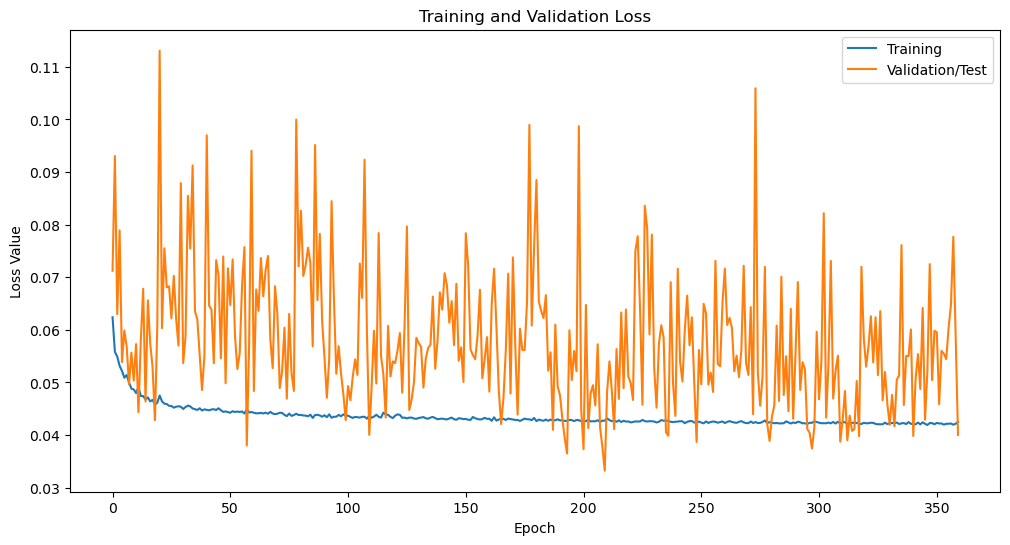

In [356]:
# Graficar el "training loss" y el "validation loss"
plt.figure(figsize=(12, 6))
plt.plot(history_model_ref_3_ins.history['mean_squared_error'], label='Training')
plt.plot(history_model_ref_3_ins.history['val_mean_squared_error'], label='Validation/Test')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

## Busqueda de hiperparametros

In [354]:
# Define el modelo dentro de una función que tomará los hiperparámetros como argumentos
def create_model(activation_1, activation_2, activation_3, activation_4, activation_5, activation_6,
    init_mode_1, init_mode_2, init_mode_3, init_mode_4, init_mode_5, init_mode_6, regularizer_type, optimizer):
    
    if regularizer_type == "l1":
        regularizer = keras.regularizers.l1(0.01)
    elif regularizer_type == "l2":
        regularizer = keras.regularizers.l2(0.01)
    else:
        regularizer = None
        
    
    model = keras.Sequential([
        keras.layers.Dense(1024, input_shape=(3,), activation=activation_1, kernel_initializer=init_mode_1, kernel_regularizer = regularizer),
        keras.layers.Dense(512, activation=activation_2, kernel_initializer=init_mode_2),
        keras.layers.Dense(256, activation=activation_3, kernel_initializer=init_mode_3),
        keras.layers.Dense(128, activation=activation_4, kernel_initializer=init_mode_4),
        keras.layers.Dense(64, activation=activation_5, kernel_initializer=init_mode_5),
        keras.layers.Dense(32, activation=activation_6, kernel_initializer=init_mode_6),
#         keras.layers.Dense(neuron_7, activation=activation_7, kernel_initializer=init_mode_7),
#         keras.layers.Dense(neuron_8, activation=activation_8, kernel_initializer=init_mode_8),
#         keras.layers.Dense(4, activation=activation_9, kernel_initializer=init_mode_9),
        keras.layers.Dense(3)
    ])
    model.compile(optimizer= optimizer,
                  loss=keras.losses.MeanSquaredError(),
                  metrics=[keras.metrics.MeanSquaredError(),])
    return model

# Función objetivo para Optuna
def objective(trial):
#     neuron_1 = trial.suggest_int('neuron_1', 3, 1024)
#     neuron_2 = trial.suggest_int('neuron_2', 3, 1024)
#     neuron_3 = trial.suggest_int('neuron_3', 3, 1024)
#     neuron_4 = trial.suggest_int('neuron_4', 3, 1024)
#     neuron_5 = trial.suggest_int('neuron_5', 3, 1024)
#     neuron_6 = trial.suggest_int('neuron_6', 3, 1024)
#     neuron_7 = trial.suggest_int('neuron_6', 3, 1024)
#     neuron_8 = trial.suggest_int('neuron_6', 3, 1024)
    
    activations_list = ["elu","exponential","hard_sigmoid","linear", "relu","selu","sigmoid","softmax","softplus",
                                                                                         "softsign","swish","tanh"]
    activation_1 = trial.suggest_categorical('activation_1', activations_list)
    activation_2 = trial.suggest_categorical('activation_2', activations_list)
    activation_3 = trial.suggest_categorical('activation_3', activations_list)
    activation_4 = trial.suggest_categorical('activation_4', activations_list)
    activation_5 = trial.suggest_categorical('activation_5', activations_list)
    activation_6 = trial.suggest_categorical('activation_6', activations_list)
#     activation_7 = trial.suggest_categorical('activation_7', activations_list)
#     activation_8 = trial.suggest_categorical('activation_8', activations_list)
#     activation_9 = trial.suggest_categorical('activation_9', activations_list)
    
    init_list = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
    init_mode_1 = trial.suggest_categorical('init_mode_1', init_list)
    init_mode_2 = trial.suggest_categorical('init_mode_2', init_list)
    init_mode_3 = trial.suggest_categorical('init_mode_3', init_list)
    init_mode_4 = trial.suggest_categorical('init_mode_4', init_list)
    init_mode_5 = trial.suggest_categorical('init_mode_5', init_list)
    init_mode_6 = trial.suggest_categorical('init_mode_6', init_list)
#     init_mode_7 = trial.suggest_categorical('init_mode_7', init_list)
#     init_mode_8 = trial.suggest_categorical('init_mode_8', init_list)
#     init_mode_9 = trial.suggest_categorical('init_mode_9', init_list)
    
    regularizer_type = trial.suggest_categorical('regularizer_type', [None, "l1", "l2"])
    
    optimizer = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])
    
    model = create_model(activation_1, activation_2, activation_3, activation_4, activation_5, activation_6,
    init_mode_1, init_mode_2, init_mode_3, init_mode_4, init_mode_5, init_mode_6, regularizer_type, optimizer)
    
    history = model.fit(x_df, y_df, epochs=10, validation_data=(x_test, y_test), verbose=0)
    
    # Usa la pérdida de validación como métrica para optimizar
    val_loss = history.history['val_mean_squared_error'][-1]
    return val_loss

# Iniciar la optimización con Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print("Mejores hiperparámetros:", study.best_params)


[I 2023-11-09 14:40:05,387] A new study created in memory with name: no-name-1f1ecd2e-a428-44f9-906c-499d96e79bc5
[I 2023-11-09 14:40:40,955] Trial 0 finished with value: 0.05078951641917229 and parameters: {'activation_1': 'softplus', 'activation_2': 'linear', 'activation_3': 'selu', 'activation_4': 'swish', 'activation_5': 'softmax', 'activation_6': 'exponential', 'init_mode_1': 'zero', 'init_mode_2': 'zero', 'init_mode_3': 'uniform', 'init_mode_4': 'normal', 'init_mode_5': 'uniform', 'init_mode_6': 'lecun_uniform', 'regularizer_type': 'l2', 'optimizer': 'Adam'}. Best is trial 0 with value: 0.05078951641917229.
[I 2023-11-09 14:41:12,559] Trial 1 finished with value: 0.051626354455947876 and parameters: {'activation_1': 'selu', 'activation_2': 'exponential', 'activation_3': 'selu', 'activation_4': 'relu', 'activation_5': 'linear', 'activation_6': 'exponential', 'init_mode_1': 'uniform', 'init_mode_2': 'glorot_normal', 'init_mode_3': 'glorot_uniform', 'init_mode_4': 'lecun_uniform', '

[I 2023-11-09 14:53:07,222] Trial 16 finished with value: 0.06786269694566727 and parameters: {'activation_1': 'hard_sigmoid', 'activation_2': 'softmax', 'activation_3': 'linear', 'activation_4': 'linear', 'activation_5': 'swish', 'activation_6': 'linear', 'init_mode_1': 'he_normal', 'init_mode_2': 'normal', 'init_mode_3': 'normal', 'init_mode_4': 'glorot_uniform', 'init_mode_5': 'uniform', 'init_mode_6': 'uniform', 'regularizer_type': None, 'optimizer': 'RMSprop'}. Best is trial 12 with value: 0.039711132645606995.
[I 2023-11-09 14:54:16,789] Trial 17 finished with value: 0.07064512372016907 and parameters: {'activation_1': 'softmax', 'activation_2': 'relu', 'activation_3': 'relu', 'activation_4': 'hard_sigmoid', 'activation_5': 'tanh', 'activation_6': 'selu', 'init_mode_1': 'he_uniform', 'init_mode_2': 'lecun_uniform', 'init_mode_3': 'lecun_uniform', 'init_mode_4': 'glorot_uniform', 'init_mode_5': 'normal', 'init_mode_6': 'normal', 'regularizer_type': None, 'optimizer': 'RMSprop'}. B

[I 2023-11-09 15:09:51,949] Trial 32 finished with value: 0.056636832654476166 and parameters: {'activation_1': 'swish', 'activation_2': 'exponential', 'activation_3': 'selu', 'activation_4': 'softsign', 'activation_5': 'linear', 'activation_6': 'hard_sigmoid', 'init_mode_1': 'zero', 'init_mode_2': 'zero', 'init_mode_3': 'normal', 'init_mode_4': 'normal', 'init_mode_5': 'uniform', 'init_mode_6': 'lecun_uniform', 'regularizer_type': None, 'optimizer': 'RMSprop'}. Best is trial 12 with value: 0.039711132645606995.
[I 2023-11-09 15:11:04,485] Trial 33 finished with value: 0.05885032191872597 and parameters: {'activation_1': 'hard_sigmoid', 'activation_2': 'softmax', 'activation_3': 'exponential', 'activation_4': 'sigmoid', 'activation_5': 'relu', 'activation_6': 'exponential', 'init_mode_1': 'zero', 'init_mode_2': 'glorot_normal', 'init_mode_3': 'uniform', 'init_mode_4': 'lecun_uniform', 'init_mode_5': 'uniform', 'init_mode_6': 'glorot_uniform', 'regularizer_type': None, 'optimizer': 'RMS

[I 2023-11-09 15:23:46,809] Trial 48 finished with value: 0.054378725588321686 and parameters: {'activation_1': 'tanh', 'activation_2': 'softplus', 'activation_3': 'linear', 'activation_4': 'elu', 'activation_5': 'selu', 'activation_6': 'softmax', 'init_mode_1': 'he_uniform', 'init_mode_2': 'lecun_uniform', 'init_mode_3': 'zero', 'init_mode_4': 'glorot_normal', 'init_mode_5': 'uniform', 'init_mode_6': 'normal', 'regularizer_type': 'l2', 'optimizer': 'RMSprop'}. Best is trial 12 with value: 0.039711132645606995.
[I 2023-11-09 15:24:48,338] Trial 49 finished with value: 0.04369107633829117 and parameters: {'activation_1': 'relu', 'activation_2': 'tanh', 'activation_3': 'sigmoid', 'activation_4': 'softmax', 'activation_5': 'softmax', 'activation_6': 'hard_sigmoid', 'init_mode_1': 'he_normal', 'init_mode_2': 'uniform', 'init_mode_3': 'he_uniform', 'init_mode_4': 'normal', 'init_mode_5': 'glorot_uniform', 'init_mode_6': 'zero', 'regularizer_type': None, 'optimizer': 'RMSprop'}. Best is tria

[I 2023-11-09 15:38:59,047] Trial 64 finished with value: 0.0556495301425457 and parameters: {'activation_1': 'relu', 'activation_2': 'softmax', 'activation_3': 'relu', 'activation_4': 'softmax', 'activation_5': 'softsign', 'activation_6': 'swish', 'init_mode_1': 'he_uniform', 'init_mode_2': 'glorot_normal', 'init_mode_3': 'he_normal', 'init_mode_4': 'he_uniform', 'init_mode_5': 'glorot_normal', 'init_mode_6': 'glorot_normal', 'regularizer_type': None, 'optimizer': 'RMSprop'}. Best is trial 12 with value: 0.039711132645606995.
[I 2023-11-09 15:39:57,603] Trial 65 finished with value: 0.06139164790511131 and parameters: {'activation_1': 'relu', 'activation_2': 'tanh', 'activation_3': 'relu', 'activation_4': 'softmax', 'activation_5': 'softsign', 'activation_6': 'hard_sigmoid', 'init_mode_1': 'he_uniform', 'init_mode_2': 'lecun_uniform', 'init_mode_3': 'he_normal', 'init_mode_4': 'normal', 'init_mode_5': 'glorot_normal', 'init_mode_6': 'glorot_normal', 'regularizer_type': None, 'optimize

[I 2023-11-09 15:54:20,986] Trial 80 finished with value: 0.05585189908742905 and parameters: {'activation_1': 'relu', 'activation_2': 'tanh', 'activation_3': 'linear', 'activation_4': 'hard_sigmoid', 'activation_5': 'selu', 'activation_6': 'linear', 'init_mode_1': 'he_uniform', 'init_mode_2': 'glorot_normal', 'init_mode_3': 'he_uniform', 'init_mode_4': 'glorot_uniform', 'init_mode_5': 'glorot_normal', 'init_mode_6': 'glorot_normal', 'regularizer_type': None, 'optimizer': 'RMSprop'}. Best is trial 12 with value: 0.039711132645606995.
[I 2023-11-09 15:54:55,946] Trial 81 finished with value: 0.052430152893066406 and parameters: {'activation_1': 'tanh', 'activation_2': 'selu', 'activation_3': 'sigmoid', 'activation_4': 'elu', 'activation_5': 'relu', 'activation_6': 'softplus', 'init_mode_1': 'zero', 'init_mode_2': 'he_normal', 'init_mode_3': 'he_uniform', 'init_mode_4': 'lecun_uniform', 'init_mode_5': 'glorot_uniform', 'init_mode_6': 'uniform', 'regularizer_type': 'l2', 'optimizer': 'SGD

[I 2023-11-09 16:10:08,023] Trial 96 finished with value: 0.0554620660841465 and parameters: {'activation_1': 'sigmoid', 'activation_2': 'softmax', 'activation_3': 'sigmoid', 'activation_4': 'hard_sigmoid', 'activation_5': 'swish', 'activation_6': 'hard_sigmoid', 'init_mode_1': 'he_uniform', 'init_mode_2': 'zero', 'init_mode_3': 'he_normal', 'init_mode_4': 'normal', 'init_mode_5': 'glorot_uniform', 'init_mode_6': 'normal', 'regularizer_type': None, 'optimizer': 'RMSprop'}. Best is trial 12 with value: 0.039711132645606995.
[I 2023-11-09 16:11:13,760] Trial 97 finished with value: 0.050173353403806686 and parameters: {'activation_1': 'swish', 'activation_2': 'exponential', 'activation_3': 'swish', 'activation_4': 'sigmoid', 'activation_5': 'swish', 'activation_6': 'hard_sigmoid', 'init_mode_1': 'lecun_uniform', 'init_mode_2': 'zero', 'init_mode_3': 'he_uniform', 'init_mode_4': 'he_normal', 'init_mode_5': 'glorot_uniform', 'init_mode_6': 'glorot_normal', 'regularizer_type': None, 'optimi

Mejores hiperparámetros: {'activation_1': 'tanh', 'activation_2': 'tanh', 'activation_3': 'sigmoid', 'activation_4': 'sigmoid', 'activation_5': 'selu', 'activation_6': 'softplus', 'init_mode_1': 'he_uniform', 'init_mode_2': 'lecun_uniform', 'init_mode_3': 'glorot_uniform', 'init_mode_4': 'glorot_uniform', 'init_mode_5': 'glorot_uniform', 'init_mode_6': 'normal', 'regularizer_type': None, 'optimizer': 'RMSprop'}


In [32]:
# Crear el modelo
model_2_ins = keras.Sequential([
    keras.layers.Dense(1024, input_shape=(2,), activation='swish', kernel_initializer='he_normal', ),
#                        kernel_regularizer = keras.regularizers.l2(0.01)),
    keras.layers.Dense(512, activation='relu', kernel_initializer='he_uniform'),
    keras.layers.Dense(256, activation='linear', kernel_initializer='glorot_uniform'),
    keras.layers.Dense(128, activation='selu', kernel_initializer='he_normal'),
    keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dense(32, activation='softsign', kernel_initializer='lecun_uniform'),
    keras.layers.Dense(3)
])


optimizer = tf.keras.optimizers.Adam(
#     learning_rate=0.001,
#     rho=0.9,
#     momentum=0.5,
#     epsilon=1e-07,
#     centered=True,
#     weight_decay=0.0001,
)

# Compilación del modelo
model_2_ins.compile(
    optimizer=optimizer,
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanSquaredError(),]
)
# Creacion de la funcion para detener el entrenamiento
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=150, mode='min' ,restore_best_weights=True)

# Entrenar el modelo y guardar el historial
history = model_2_ins.fit(x2_df,  y2_df, epochs=5000, validation_data=(x2_test, y2_test), callbacks=[callback])

model_2_ins.evaluate(x2_test, y2_test)

Epoch 1/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0619 - mean_squared_error: 0.0619 - val_loss: 0.1062 - val_mean_squared_error: 0.1062
Epoch 2/5000
731/731 [==============================] - 3s 5ms/step - loss: 0.0568 - mean_squared_error: 0.0568 - val_loss: 0.0605 - val_mean_squared_error: 0.0605
Epoch 3/5000
731/731 [==============================] - 3s 5ms/step - loss: 0.0557 - mean_squared_error: 0.0557 - val_loss: 0.0819 - val_mean_squared_error: 0.0819
Epoch 4/5000
731/731 [==============================] - 3s 5ms/step - loss: 0.0550 - mean_squared_error: 0.0550 - val_loss: 0.0745 - val_mean_squared_error: 0.0745
Epoch 5/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0547 - mean_squared_error: 0.0547 - val_loss: 0.0867 - val_mean_squared_error: 0.0867
Epoch 6/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0538 - mean_squared_error: 0.0538 - val_loss: 0.0797 - val_mean_squared_error: 0.0797
Epoch 7/5000
731

Epoch 51/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0443 - mean_squared_error: 0.0443 - val_loss: 0.0623 - val_mean_squared_error: 0.0623
Epoch 52/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0444 - mean_squared_error: 0.0444 - val_loss: 0.0386 - val_mean_squared_error: 0.0386
Epoch 53/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0445 - mean_squared_error: 0.0445 - val_loss: 0.0368 - val_mean_squared_error: 0.0368
Epoch 54/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0446 - mean_squared_error: 0.0446 - val_loss: 0.0410 - val_mean_squared_error: 0.0410
Epoch 55/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0446 - mean_squared_error: 0.0446 - val_loss: 0.0479 - val_mean_squared_error: 0.0479
Epoch 56/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0445 - mean_squared_error: 0.0445 - val_loss: 0.0440 - val_mean_squared_error: 0.0440
Epoch 57/5

731/731 [==============================] - 4s 6ms/step - loss: 0.0438 - mean_squared_error: 0.0438 - val_loss: 0.1094 - val_mean_squared_error: 0.1094
Epoch 150/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0441 - mean_squared_error: 0.0441 - val_loss: 0.0876 - val_mean_squared_error: 0.0876
Epoch 151/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0434 - mean_squared_error: 0.0434 - val_loss: 0.0867 - val_mean_squared_error: 0.0867
Epoch 152/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0439 - mean_squared_error: 0.0439 - val_loss: 0.1090 - val_mean_squared_error: 0.1090
Epoch 153/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0436 - mean_squared_error: 0.0436 - val_loss: 0.0688 - val_mean_squared_error: 0.0688
Epoch 154/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0438 - mean_squared_error: 0.0438 - val_loss: 0.0904 - val_mean_squared_error: 0.0904
Epoch 155/5000
731/

[0.03675910085439682, 0.03675910085439682]

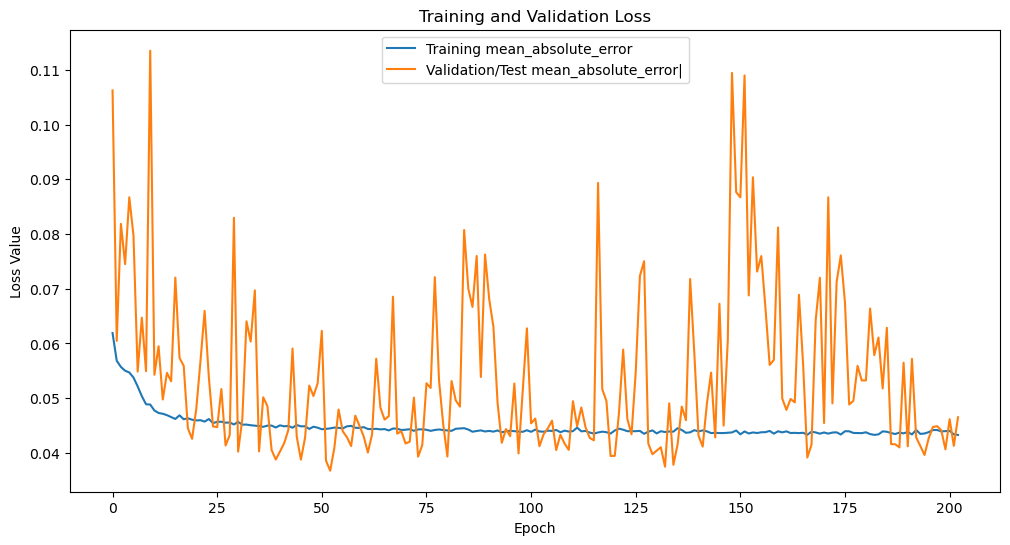

In [35]:
# Graficar el "training loss" y el "validation loss"
plt.figure(figsize=(12, 6))
plt.plot(history.history['mean_squared_error'], label='Training mean_absolute_error')
plt.plot(history.history['val_mean_squared_error'], label='Validation/Test mean_absolute_error|')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

In [18]:
# Crear el modelo
model_3_ins = keras.Sequential([
    keras.layers.Dense(1024, input_shape=(3,), activation='swish', kernel_initializer='he_normal', ),
#                        kernel_regularizer = keras.regularizers.l2(0.01)),
    keras.layers.Dense(512, activation='relu', kernel_initializer='he_uniform'),
    keras.layers.Dense(256, activation='linear', kernel_initializer='glorot_uniform'),
    keras.layers.Dense(128, activation='selu', kernel_initializer='he_normal'),
    keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dense(32, activation='softsign', kernel_initializer='lecun_uniform'),
    keras.layers.Dense(3)
])


optimizer = tf.keras.optimizers.Adam(
#     learning_rate=0.001,
#     rho=0.9,
#     momentum=0.5,
#     epsilon=1e-07,
#     centered=True,
#     weight_decay=0.0001,
)

# Compilación del modelo
model_3_ins.compile(
    optimizer=optimizer,
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanSquaredError(),]
)

# Creacion de la funcion para detener el entrenamiento
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=150, mode='min' ,restore_best_weights=True)
    
with tf.device('/device:GPU:0'):
    
# Entrenar el modelo y guardar el historial
    history_model_3_ins = model_3_ins.fit(x_df,  y_df, epochs=5000, validation_data=(x_test, y_test), callbacks=[callback])

model_3_ins.evaluate(x_test, y_test)

Epoch 1/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0607 - mean_squared_error: 0.0607 - val_loss: 0.0903 - val_mean_squared_error: 0.0903
Epoch 2/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0540 - mean_squared_error: 0.0540 - val_loss: 0.0593 - val_mean_squared_error: 0.0593
Epoch 3/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0522 - mean_squared_error: 0.0522 - val_loss: 0.0495 - val_mean_squared_error: 0.0495
Epoch 4/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0500 - mean_squared_error: 0.0500 - val_loss: 0.0423 - val_mean_squared_error: 0.0423
Epoch 5/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0490 - mean_squared_error: 0.0490 - val_loss: 0.0702 - val_mean_squared_error: 0.0702
Epoch 6/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0482 - mean_squared_error: 0.0482 - val_loss: 0.0610 - val_mean_squared_error: 0.0610
Epoch 7/5000
731

Epoch 51/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0477 - val_mean_squared_error: 0.0477
Epoch 52/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0460 - val_mean_squared_error: 0.0460
Epoch 53/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0435 - mean_squared_error: 0.0435 - val_loss: 0.0454 - val_mean_squared_error: 0.0454
Epoch 54/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0435 - mean_squared_error: 0.0435 - val_loss: 0.0451 - val_mean_squared_error: 0.0451
Epoch 55/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0544 - val_mean_squared_error: 0.0544
Epoch 56/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0439 - mean_squared_error: 0.0439 - val_loss: 0.0853 - val_mean_squared_error: 0.0853
Epoch 57/5

731/731 [==============================] - 4s 5ms/step - loss: 0.0428 - mean_squared_error: 0.0428 - val_loss: 0.0453 - val_mean_squared_error: 0.0453
Epoch 150/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0431 - mean_squared_error: 0.0431 - val_loss: 0.1085 - val_mean_squared_error: 0.1085
Epoch 151/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0428 - mean_squared_error: 0.0428 - val_loss: 0.0991 - val_mean_squared_error: 0.0991
Epoch 152/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0432 - mean_squared_error: 0.0432 - val_loss: 0.1005 - val_mean_squared_error: 0.1005
Epoch 153/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0428 - mean_squared_error: 0.0428 - val_loss: 0.0411 - val_mean_squared_error: 0.0411
Epoch 154/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0427 - mean_squared_error: 0.0427 - val_loss: 0.0497 - val_mean_squared_error: 0.0497
Epoch 155/5000
731/

731/731 [==============================] - 3s 4ms/step - loss: 0.0426 - mean_squared_error: 0.0426 - val_loss: 0.0400 - val_mean_squared_error: 0.0400
Epoch 248/5000
731/731 [==============================] - 3s 5ms/step - loss: 0.0426 - mean_squared_error: 0.0426 - val_loss: 0.0408 - val_mean_squared_error: 0.0408
Epoch 249/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0425 - mean_squared_error: 0.0425 - val_loss: 0.0496 - val_mean_squared_error: 0.0496
Epoch 250/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0426 - mean_squared_error: 0.0426 - val_loss: 0.1340 - val_mean_squared_error: 0.1340
Epoch 251/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0430 - mean_squared_error: 0.0430 - val_loss: 0.1120 - val_mean_squared_error: 0.1120
Epoch 252/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0426 - mean_squared_error: 0.0426 - val_loss: 0.0882 - val_mean_squared_error: 0.0882
Epoch 253/5000
731/

731/731 [==============================] - 4s 6ms/step - loss: 0.0423 - mean_squared_error: 0.0423 - val_loss: 0.1098 - val_mean_squared_error: 0.1098
Epoch 346/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0429 - mean_squared_error: 0.0429 - val_loss: 0.1094 - val_mean_squared_error: 0.1094
Epoch 347/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0422 - mean_squared_error: 0.0422 - val_loss: 0.4399 - val_mean_squared_error: 0.4399
Epoch 348/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0425 - mean_squared_error: 0.0425 - val_loss: 0.1577 - val_mean_squared_error: 0.1577
Epoch 349/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0424 - mean_squared_error: 0.0424 - val_loss: 0.1083 - val_mean_squared_error: 0.1083
Epoch 350/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0423 - mean_squared_error: 0.0423 - val_loss: 0.1308 - val_mean_squared_error: 0.1308
Epoch 351/5000
731/

[0.03349746763706207, 0.03349746763706207]

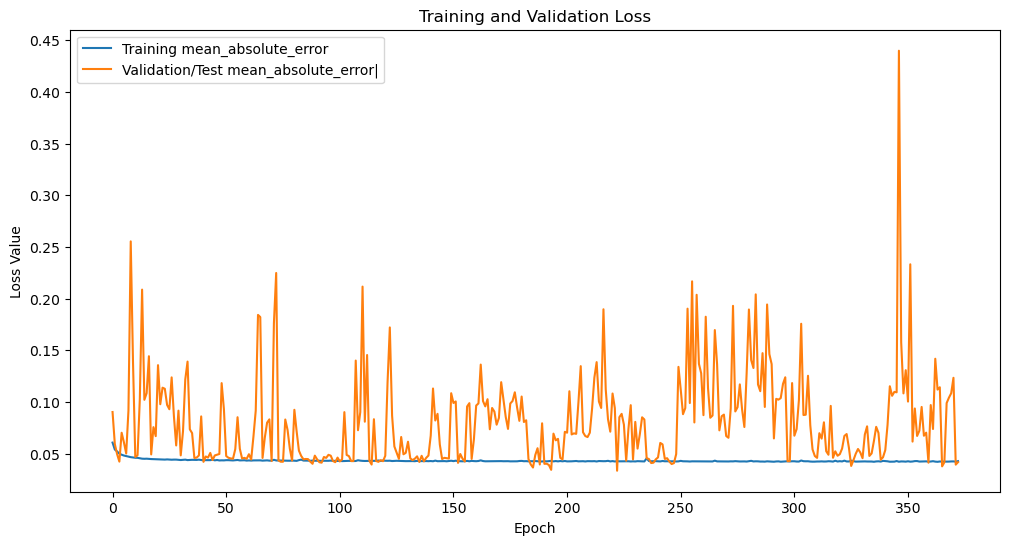

In [19]:
# Graficar el "training loss" y el "validation loss"
plt.figure(figsize=(12, 6))
plt.plot(history_model_3_ins.history['mean_squared_error'], label='Training mean_absolute_error')
plt.plot(history_model_3_ins.history['val_mean_squared_error'], label='Validation/Test mean_absolute_error|')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

In [40]:
# Crear el modelo
start=perf_counter()

model_3_ins_1 = None
model_3_ins_1 = keras.Sequential([
    keras.layers.Dense(1024, input_shape=(3,), activation='swish', kernel_initializer='he_normal', ),
#                        kernel_regularizer = keras.regularizers.l2(0.01)),
    keras.layers.Dense(512, activation='relu', kernel_initializer='he_uniform'),
    keras.layers.Dense(256, activation='linear', kernel_initializer='glorot_uniform'),
    keras.layers.Dense(128, activation='selu', kernel_initializer='he_normal'),
    keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dense(32, activation='softsign', kernel_initializer='lecun_uniform'),
    keras.layers.Dense(3)
])


optimizer = tf.keras.optimizers.Adam(
#     learning_rate=0.001,
#     rho=0.9,
#     momentum=0.5,
#     epsilon=1e-07,
#     centered=True,
#     weight_decay=0.0001,
)

# Compilación del modelo
model_3_ins_1.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanAbsolutePercentageError(),]
)

# Creacion de la funcion para detener el entrenamiento
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_percentage_error', patience=150, mode='min' ,restore_best_weights=True)
    
# Entrenar el modelo y guardar el historial
history_model_3_ins_1 = model_3_ins_1.fit(x_df,  y_df, epochs=5000, validation_data=(x_test, y_test), callbacks=[callback])

tl=(perf_counter()-start)/60
print ('Elapsed time: %.2f hrs.' %tl)

model_3_ins_1.evaluate(x_test, y_test)

Epoch 1/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0622 - mean_absolute_percentage_error: 79.0168 - val_loss: 0.0620 - val_mean_absolute_percentage_error: 33.4709
Epoch 2/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0549 - mean_absolute_percentage_error: 72.5860 - val_loss: 0.0614 - val_mean_absolute_percentage_error: 35.3475
Epoch 3/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0528 - mean_absolute_percentage_error: 68.3835 - val_loss: 0.0603 - val_mean_absolute_percentage_error: 33.7018
Epoch 4/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0507 - mean_absolute_percentage_error: 63.8929 - val_loss: 0.0434 - val_mean_absolute_percentage_error: 33.7062
Epoch 5/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0498 - mean_absolute_percentage_error: 61.8869 - val_loss: 0.0480 - val_mean_absolute_percentage_error: 34.0561
Epoch 6/5000
731/731 [============================

Epoch 44/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0443 - mean_absolute_percentage_error: 53.4657 - val_loss: 0.1102 - val_mean_absolute_percentage_error: 42.8270
Epoch 45/5000
731/731 [==============================] - 5s 6ms/step - loss: 0.0441 - mean_absolute_percentage_error: 53.4233 - val_loss: 0.0600 - val_mean_absolute_percentage_error: 36.4253
Epoch 46/5000
731/731 [==============================] - 5s 6ms/step - loss: 0.0442 - mean_absolute_percentage_error: 53.7673 - val_loss: 0.0599 - val_mean_absolute_percentage_error: 33.7879
Epoch 47/5000
731/731 [==============================] - 5s 6ms/step - loss: 0.0441 - mean_absolute_percentage_error: 53.2478 - val_loss: 0.0460 - val_mean_absolute_percentage_error: 30.4588
Epoch 48/5000
731/731 [==============================] - 5s 6ms/step - loss: 0.0439 - mean_absolute_percentage_error: 53.1541 - val_loss: 0.0500 - val_mean_absolute_percentage_error: 32.4849
Epoch 49/5000
731/731 [======================

Epoch 87/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0437 - mean_absolute_percentage_error: 52.9019 - val_loss: 0.0525 - val_mean_absolute_percentage_error: 33.1340
Epoch 88/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0436 - mean_absolute_percentage_error: 52.6642 - val_loss: 0.0365 - val_mean_absolute_percentage_error: 30.8426
Epoch 89/5000
731/731 [==============================] - 5s 6ms/step - loss: 0.0438 - mean_absolute_percentage_error: 53.0935 - val_loss: 0.0436 - val_mean_absolute_percentage_error: 32.1806
Epoch 90/5000
731/731 [==============================] - 5s 6ms/step - loss: 0.0446 - mean_absolute_percentage_error: 54.0652 - val_loss: 0.0413 - val_mean_absolute_percentage_error: 32.2169
Epoch 91/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0451 - mean_absolute_percentage_error: 54.5208 - val_loss: 0.0675 - val_mean_absolute_percentage_error: 33.5287
Epoch 92/5000
731/731 [======================

Epoch 130/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0434 - mean_absolute_percentage_error: 52.5419 - val_loss: 0.0447 - val_mean_absolute_percentage_error: 32.1767
Epoch 131/5000
731/731 [==============================] - 5s 6ms/step - loss: 0.0432 - mean_absolute_percentage_error: 52.3871 - val_loss: 0.0587 - val_mean_absolute_percentage_error: 33.7177
Epoch 132/5000
731/731 [==============================] - 5s 6ms/step - loss: 0.0435 - mean_absolute_percentage_error: 52.7740 - val_loss: 0.0464 - val_mean_absolute_percentage_error: 31.1504
Epoch 133/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0433 - mean_absolute_percentage_error: 52.4559 - val_loss: 0.0602 - val_mean_absolute_percentage_error: 34.5595
Epoch 134/5000
731/731 [==============================] - 5s 6ms/step - loss: 0.0434 - mean_absolute_percentage_error: 52.6277 - val_loss: 0.1093 - val_mean_absolute_percentage_error: 42.9143
Epoch 135/5000
731/731 [================

Epoch 173/5000
731/731 [==============================] - 3s 5ms/step - loss: 0.0434 - mean_absolute_percentage_error: 52.4780 - val_loss: 0.3352 - val_mean_absolute_percentage_error: 48.6623
Epoch 174/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0433 - mean_absolute_percentage_error: 52.4687 - val_loss: 0.4708 - val_mean_absolute_percentage_error: 57.9808
Epoch 175/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0433 - mean_absolute_percentage_error: 52.7371 - val_loss: 0.0914 - val_mean_absolute_percentage_error: 38.4473
Epoch 176/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0430 - mean_absolute_percentage_error: 52.1314 - val_loss: 0.1978 - val_mean_absolute_percentage_error: 46.5057
Epoch 177/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0431 - mean_absolute_percentage_error: 52.0264 - val_loss: 0.1602 - val_mean_absolute_percentage_error: 42.6302
Epoch 178/5000
731/731 [================

[0.03712292015552521, 27.90331268310547]

In [ ]:
22.25

14.24

In [ ]:
# Graficar el "training loss" y el "validation loss"
plt.figure(figsize=(12, 6))
plt.plot(history_model_3_ins_1.history['mean_squared_error'], label='Training mean_absolute_error')
plt.plot(history_model_3_ins_1.history['val_mean_squared_error'], label='Validation/Test mean_absolute_error|')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

In [384]:
# Crear el modelo
model_3_ins_2 = None
model_3_ins_2 = keras.Sequential([
    keras.layers.Dense(1024, input_shape=(3,), activation='swish', kernel_initializer='he_normal', ),
#                        kernel_regularizer = keras.regularizers.l2(0.01)),
    keras.layers.Dense(512, activation='relu', kernel_initializer='he_uniform'),
    keras.layers.Dense(256, activation='linear', kernel_initializer='glorot_uniform'),
    keras.layers.Dense(128, activation='selu', kernel_initializer='he_normal'),
    keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dense(32, activation='softsign', kernel_initializer='lecun_uniform'),
    keras.layers.Dense(3)
])


# optimizer = tf.keras.optimizers.Adam(
# #     learning_rate=0.001,
# #     rho=0.9,
# #     momentum=0.5,
# #     epsilon=1e-07,
# #     centered=True,
# #     weight_decay=0.0001,
# )

# Compilación del modelo
model_3_ins_2.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanSquaredError(),]
)

# Creacion de la funcion para detener el entrenamiento
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=150, mode='min' ,restore_best_weights=True)
    
with tf.device('/device:GPU:0'):
    
# Entrenar el modelo y guardar el historial
    history_model_3_ins_2 = model_3_ins_2.fit(x_df,  y_df, epochs=5000, validation_data=(x_test, y_test), callbacks=[callback])

model_3_ins_2.evaluate(x_test, y_test)

Epoch 1/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0656 - mean_squared_error: 0.0656 - val_loss: 0.0721 - val_mean_squared_error: 0.0721
Epoch 2/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0555 - mean_squared_error: 0.0555 - val_loss: 0.0920 - val_mean_squared_error: 0.0920
Epoch 3/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0529 - mean_squared_error: 0.0529 - val_loss: 0.0630 - val_mean_squared_error: 0.0630
Epoch 4/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0512 - mean_squared_error: 0.0512 - val_loss: 0.0495 - val_mean_squared_error: 0.0495
Epoch 5/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0505 - mean_squared_error: 0.0505 - val_loss: 0.0469 - val_mean_squared_error: 0.0469
Epoch 6/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0497 - mean_squared_error: 0.0497 - val_loss: 0.0420 - val_mean_squared_error: 0.0420
Epoch 7/5000
731

Epoch 51/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0436 - mean_squared_error: 0.0436 - val_loss: 0.0634 - val_mean_squared_error: 0.0634
Epoch 52/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0398 - val_mean_squared_error: 0.0398
Epoch 53/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0438 - mean_squared_error: 0.0438 - val_loss: 0.2031 - val_mean_squared_error: 0.2031
Epoch 54/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0439 - mean_squared_error: 0.0439 - val_loss: 0.0569 - val_mean_squared_error: 0.0569
Epoch 55/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0435 - mean_squared_error: 0.0435 - val_loss: 0.0565 - val_mean_squared_error: 0.0565
Epoch 56/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0434 - mean_squared_error: 0.0434 - val_loss: 0.0569 - val_mean_squared_error: 0.0569
Epoch 57/5

731/731 [==============================] - 4s 5ms/step - loss: 0.0433 - mean_squared_error: 0.0433 - val_loss: 0.0819 - val_mean_squared_error: 0.0819
Epoch 150/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0430 - mean_squared_error: 0.0430 - val_loss: 0.0492 - val_mean_squared_error: 0.0492
Epoch 151/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0431 - mean_squared_error: 0.0431 - val_loss: 0.2602 - val_mean_squared_error: 0.2602
Epoch 152/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0433 - mean_squared_error: 0.0433 - val_loss: 0.1457 - val_mean_squared_error: 0.1457
Epoch 153/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0431 - mean_squared_error: 0.0431 - val_loss: 0.0511 - val_mean_squared_error: 0.0511
Epoch 154/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0431 - mean_squared_error: 0.0431 - val_loss: 0.1281 - val_mean_squared_error: 0.1281
Epoch 155/5000
731/

731/731 [==============================] - 4s 5ms/step - loss: 0.0429 - mean_squared_error: 0.0429 - val_loss: 0.0588 - val_mean_squared_error: 0.0588
Epoch 248/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0430 - mean_squared_error: 0.0430 - val_loss: 0.0711 - val_mean_squared_error: 0.0711
Epoch 249/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0430 - mean_squared_error: 0.0430 - val_loss: 0.0441 - val_mean_squared_error: 0.0441
Epoch 250/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0430 - mean_squared_error: 0.0430 - val_loss: 0.1162 - val_mean_squared_error: 0.1162
Epoch 251/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0428 - mean_squared_error: 0.0428 - val_loss: 0.1924 - val_mean_squared_error: 0.1924
Epoch 252/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0432 - mean_squared_error: 0.0432 - val_loss: 0.0366 - val_mean_squared_error: 0.0366
Epoch 253/5000
731/

731/731 [==============================] - 4s 5ms/step - loss: 0.0434 - mean_squared_error: 0.0434 - val_loss: 0.4197 - val_mean_squared_error: 0.4197
Epoch 346/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0427 - mean_squared_error: 0.0427 - val_loss: 0.3377 - val_mean_squared_error: 0.3377
Epoch 347/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0426 - mean_squared_error: 0.0426 - val_loss: 0.4729 - val_mean_squared_error: 0.4729
Epoch 348/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0431 - mean_squared_error: 0.0431 - val_loss: 0.4538 - val_mean_squared_error: 0.4538
Epoch 349/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0428 - mean_squared_error: 0.0428 - val_loss: 0.5261 - val_mean_squared_error: 0.5261
Epoch 350/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0465 - mean_squared_error: 0.0465 - val_loss: 0.0504 - val_mean_squared_error: 0.0504
Epoch 351/5000
731/

[0.036182548850774765, 0.036182548850774765]

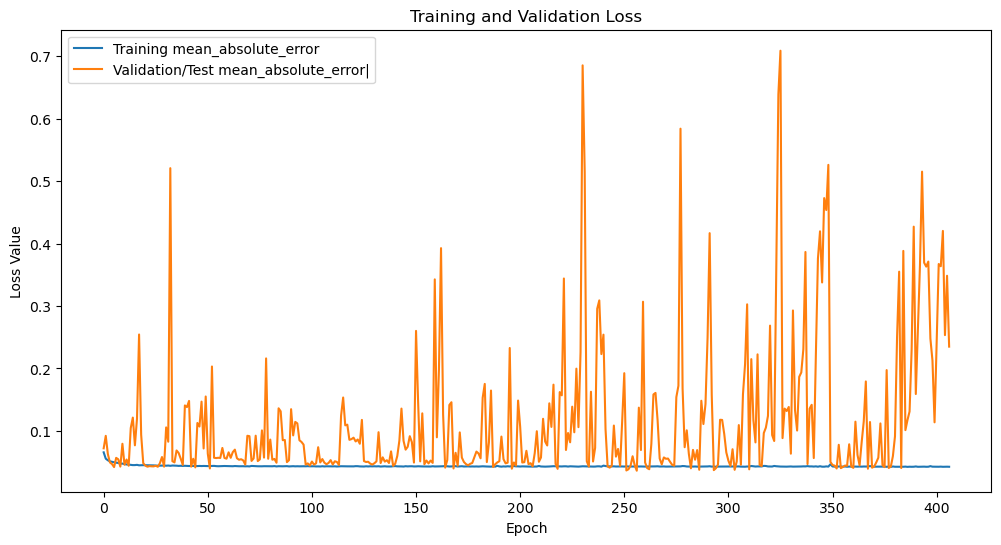

In [385]:
# Graficar el "training loss" y el "validation loss"
plt.figure(figsize=(12, 6))
plt.plot(history_model_3_ins_2.history['mean_squared_error'], label='Training mean_absolute_error')
plt.plot(history_model_3_ins_2.history['val_mean_squared_error'], label='Validation/Test mean_absolute_error|')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

# KNRegressor en cascada

In [48]:
df_R = df.drop(['DEE','Remb'],axis=1)
df_R.head()

,R,r,g,b
1000,0.791341,0.722932,0.580025,0.566105
1001,0.548232,0.644540,0.617104,0.579985
1002,0.911335,0.616763,0.655954,0.552336
1003,0.955045,0.659497,0.598786,0.589842
1004,0.053760,0.610322,0.609427,0.607590


In [49]:
df_DEE = df.drop(['R','Remb'],axis=1)
df_DEE.head()

,DEE,r,g,b
1000,0.322651,0.722932,0.580025,0.566105
1001,0.332888,0.644540,0.617104,0.579985
1002,0.808626,0.616763,0.655954,0.552336
1003,0.660524,0.659497,0.598786,0.589842
1004,0.803732,0.610322,0.609427,0.607590


In [50]:
df_Remb = df.drop(['DEE','R'],axis=1)
df_Remb.head()

,Remb,r,g,b
1000,0.7547,0.722932,0.580025,0.566105
1001,0.6853,0.644540,0.617104,0.579985
1002,0.4581,0.616763,0.655954,0.552336
1003,0.9566,0.659497,0.598786,0.589842
1004,0.4182,0.610322,0.609427,0.607590


## Data Split en test y training

In [51]:
# R
df_R = utils.shuffle(df_R, random_state = 10)

R_x_train = df_R.drop(['R'],axis=1) 
R_x_test = test[['r','g','b']]
R_y_train = df_R['R']
R_y_test = test['R']
R_x_train.shape,R_x_test.shape

((23368, 3), (1000, 3))

In [52]:
# DEE
df_DEE = utils.shuffle(df_DEE, random_state = 20)
DEE_x_train = df_DEE.drop(['DEE'],axis=1) 
DEE_x_test = test[['r','g','b']]
DEE_y_train = df_DEE['DEE']
DEE_y_test = test['DEE']
DEE_x_train.shape,DEE_x_test.shape

((23368, 3), (1000, 3))

In [53]:
# Remb
df_Remb = utils.shuffle(df_Remb, random_state = 30)
Remb_x_train = df_Remb.drop(['Remb'],axis=1) 
Remb_x_test = test[['r','g','b']]
Remb_y_train = df_Remb['Remb']
Remb_y_test = test['Remb']
Remb_x_train.shape,Remb_x_test.shape

((23368, 3), (1000, 3))

## Parametro Remb

In [54]:
Remb_model_knn = KNeighborsRegressor(n_neighbors = 36, weights = 'distance', metric = 'manhattan',)
Remb_model_knn.fit(Remb_x_train, Remb_y_train)

KNeighborsRegressor(metric='manhattan', n_neighbors=36, weights='distance')

In [63]:
remb_knn_pred = Remb_model_knn.predict(Remb_x_test)
mse_1 = mean_squared_error(Remb_y_test, remb_knn_pred)
print(mse_1)

0.0446786722441


## Parametro R

In [56]:
R_x_train['Remb_pred'] = Remb_model_knn.predict(R_x_train)
R_x_test['Remb_pred'] = Remb_model_knn.predict(R_x_test)
R_x_train.head()

C:\Users\Private Richi\AppData\Local\Temp\ipykernel_288\318137960.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  R_x_test['Remb_pred'] = Remb_model_knn.predict(R_x_test)


,r,g,b,Remb_pred
2854,0.626221,0.636947,0.569158,0.579300
2694,0.612751,0.607145,0.608541,0.587800
16927,0.589422,0.574468,0.650176,0.781500
10877,0.741430,0.491024,0.629866,0.690802
10195,0.666268,0.548937,0.631429,0.774610


In [57]:
R_model_knn = KNeighborsRegressor(n_neighbors = 10, weights = 'distance', metric = 'manhattan', )
R_model_knn.fit(R_x_train, R_y_train)

KNeighborsRegressor(metric='manhattan', n_neighbors=10, weights='distance')

In [64]:
knn_pred = R_model_knn.predict(R_x_test)
mse_2 = mean_squared_error(R_y_test, knn_pred)
print(mse_2)

0.0596014556834


## Parametro DEE

In [59]:
DEE_x_train['Remb_pred'] = Remb_model_knn.predict(DEE_x_train)
DEE_x_test['Remb_pred'] = Remb_model_knn.predict(DEE_x_test)
DEE_x_train['R_pred'] = R_model_knn.predict(DEE_x_train)
DEE_x_test['R_pred'] = R_model_knn.predict(DEE_x_test)
DEE_x_train.head()

C:\Users\Private Richi\AppData\Local\Temp\ipykernel_288\2464648805.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DEE_x_test['Remb_pred'] = Remb_model_knn.predict(DEE_x_test)
C:\Users\Private Richi\AppData\Local\Temp\ipykernel_288\2464648805.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DEE_x_test['R_pred'] = R_model_knn.predict(DEE_x_test)


,r,g,b,Remb_pred,R_pred
21306,0.537730,0.572749,0.674111,0.7400,0.322473
8238,0.611967,0.680585,0.523135,0.8305,0.397255
13829,0.675925,0.642352,0.529542,0.3000,0.259458
3593,0.524794,0.589034,0.665828,0.8245,0.284218
19614,0.653908,0.632135,0.557236,0.7606,0.402051


In [60]:
DEE_model_knn = KNeighborsRegressor(n_neighbors = 10, weights = 'distance', metric = 'manhattan',)
DEE_model_knn.fit(DEE_x_train, DEE_y_train)

KNeighborsRegressor(metric='manhattan', n_neighbors=10, weights='distance')

In [65]:
dee_knn_pred = DEE_model_knn.predict(DEE_x_test)
mse_3 = mean_squared_error(DEE_y_test, dee_knn_pred)
print(mse_3)

0.113248392736


In [66]:
(mse_1 + mse_2 + mse_3)/3

0.072509506887866268

**Rango**: 0 ≤ MAE <∞  

In [ ]:
array = test[['r','g','b']]


In [ ]:
predict = knn_m.predict(array)

In [ ]:
pred = pd.DataFrame(predict)

In [ ]:
pred

In [ ]:
test[['R','DEE','Remb']]

# Autoencoder Tandem

In [ ]:
################################################################################

In [ ]:
input_enc = keras.layers.Input(shape = (x_df.shape[1],))
enc = keras.layers.Dense(950, activation='relu')(input_enc)
enc = keras.Sequential([
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(3)
])(enc)

encoder = keras.models.Model(input_enc, enc)

In [195]:
input_dec = keras.layers.Input(shape = (2,))
dec = keras.layers.Dense(950, activation='relu')(input_dec)
dec  = keras.Sequential([
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(950, activation = 'relu'),
    keras.layers.Dense(3)
])(dec)

decoder = keras.models.Model(input_dec, dec)

decoder.compile(
    optimizer=keras.optimizers.Adam(),
    loss = keras.losses.MeanSquaredError(),
    metrics = keras.metrics.MeanSquaredError()
)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=150)

history = decoder.fit(x2_df,  y2_df, epochs=5000, validation_data=(x2_test, y2_test), callbacks=[callback])

Epoch 1/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0656 - mean_squared_error: 0.0656 - val_loss: 0.0712 - val_mean_squared_error: 0.0712
Epoch 2/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0571 - mean_squared_error: 0.0571 - val_loss: 0.0658 - val_mean_squared_error: 0.0658
Epoch 3/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0551 - mean_squared_error: 0.0551 - val_loss: 0.0680 - val_mean_squared_error: 0.0680
Epoch 4/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0553 - mean_squared_error: 0.0553 - val_loss: 0.0724 - val_mean_squared_error: 0.0724
Epoch 5/5000
731/731 [==============================] - 5s 6ms/step - loss: 0.0544 - mean_squared_error: 0.0544 - val_loss: 0.0629 - val_mean_squared_error: 0.0629
Epoch 6/5000
731/731 [==============================] - 5s 6ms/step - loss: 0.0533 - mean_squared_error: 0.0533 - val_loss: 0.0590 - val_mean_squared_error: 0.0590
Epoch 7/5000
731

Epoch 51/5000
731/731 [==============================] - 5s 6ms/step - loss: 0.0453 - mean_squared_error: 0.0453 - val_loss: 0.0498 - val_mean_squared_error: 0.0498
Epoch 52/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0458 - mean_squared_error: 0.0458 - val_loss: 0.0573 - val_mean_squared_error: 0.0573
Epoch 53/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0453 - mean_squared_error: 0.0453 - val_loss: 0.0511 - val_mean_squared_error: 0.0511
Epoch 54/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0451 - mean_squared_error: 0.0451 - val_loss: 0.0501 - val_mean_squared_error: 0.0501
Epoch 55/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0451 - mean_squared_error: 0.0451 - val_loss: 0.0565 - val_mean_squared_error: 0.0565
Epoch 56/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0452 - mean_squared_error: 0.0452 - val_loss: 0.0521 - val_mean_squared_error: 0.0521
Epoch 57/5

731/731 [==============================] - 4s 6ms/step - loss: 0.0438 - mean_squared_error: 0.0438 - val_loss: 0.0460 - val_mean_squared_error: 0.0460
Epoch 150/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0435 - mean_squared_error: 0.0435 - val_loss: 0.0439 - val_mean_squared_error: 0.0439
Epoch 151/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0436 - mean_squared_error: 0.0436 - val_loss: 0.0464 - val_mean_squared_error: 0.0464
Epoch 152/5000
731/731 [==============================] - 4s 5ms/step - loss: 0.0435 - mean_squared_error: 0.0435 - val_loss: 0.0457 - val_mean_squared_error: 0.0457
Epoch 153/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0441 - mean_squared_error: 0.0441 - val_loss: 0.0538 - val_mean_squared_error: 0.0538
Epoch 154/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0438 - mean_squared_error: 0.0438 - val_loss: 0.0448 - val_mean_squared_error: 0.0448
Epoch 155/5000
731/

731/731 [==============================] - 4s 6ms/step - loss: 0.0431 - mean_squared_error: 0.0431 - val_loss: 0.0616 - val_mean_squared_error: 0.0616
Epoch 248/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0432 - mean_squared_error: 0.0432 - val_loss: 0.0700 - val_mean_squared_error: 0.0700
Epoch 249/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0429 - mean_squared_error: 0.0429 - val_loss: 0.0465 - val_mean_squared_error: 0.0465
Epoch 250/5000
731/731 [==============================] - 5s 6ms/step - loss: 0.0430 - mean_squared_error: 0.0430 - val_loss: 0.0497 - val_mean_squared_error: 0.0497
Epoch 251/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0433 - mean_squared_error: 0.0433 - val_loss: 0.0470 - val_mean_squared_error: 0.0470
Epoch 252/5000
731/731 [==============================] - 4s 6ms/step - loss: 0.0432 - mean_squared_error: 0.0432 - val_loss: 0.0490 - val_mean_squared_error: 0.0490
Epoch 253/5000
731/

In [196]:
decoder.evaluate(x2_test, y2_test)

32/32 [==============================] - 0s 3ms/step - loss: 0.0590 - mean_squared_error: 0.0590


[0.05903993546962738, 0.05903993546962738]

In [ ]:
autoencoder_input = keras.layers.Input(shape=(3,))
encoded_repr = encoder(autoencoder_input)
reconstructed = decoder(encoded_repr)

autoencoder = keras.models.Model(autoencoder_input, reconstructed)

autoencoder.compile(
    optimizer='Adamax',
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanAbsoluteError(),]
)
callback = tf.keras.callbacks.EarlyStopping(monitor='mean_absolute_error', patience=10)

In [ ]:
autoencoder.fit(x_df,  y_df, epochs=10, validation_data=(x_test, y_test),callbacks=[callback])

In [ ]:
autoencoder.evaluate(test.drop(['R', 'DEE', 'Remb'],axis=1), test[['R', 'DEE', 'Remb']])

In [ ]:
def create_model(activation_1, activation_2, activation_3, activation_4, activation_5, activation_6, activation_7, activation_8,
                 activation_9, activation_10,  init_mode_1, init_mode_2, init_mode_3, init_mode_4, init_mode_5, init_mode_6, 
                init_mode_7, init_mode_8, init_mode_9, init_mode_10, optimizer):

    input_enc = keras.layers.Input(shape = (x_df.shape[1],))
    enc = keras.layers.Dense(3, activation=activation_1, kernel_initializer=init_mode_1)(input_enc)
    enc = keras.Sequential([
        keras.layers.Dense(3, activation=activation_2, kernel_initializer=init_mode_2),
        keras.layers.Dense(3, activation=activation_3, kernel_initializer=init_mode_3),
        keras.layers.Dense(3, activation=activation_4, kernel_initializer=init_mode_4),
        keras.layers.Dense(3, activation=activation_5, kernel_initializer=init_mode_5),
        keras.layers.Dense(3)
    ])(enc)

    input_dec = keras.layers.Input(shape = (3,))
    dec = keras.layers.Dense(3, activation=activation_6, kernel_initializer=init_mode_6)(input_dec)
    dec  = keras.Sequential([
        keras.layers.Dense(3, activation=activation_7, kernel_initializer=init_mode_7),
        keras.layers.Dense(3, activation=activation_8, kernel_initializer=init_mode_8),
        keras.layers.Dense(3, activation=activation_9, kernel_initializer=init_mode_9),
        keras.layers.Dense(3, activation=activation_10, kernel_initializer=init_mode_10),
        keras.layers.Dense(3)
    ])(dec)
    
    encoder = keras.models.Model(input_enc, enc)
    decoder = keras.models.Model(input_dec, dec)

    autoencoder_input = keras.layers.Input(shape=(3,))
    encoded_repr = encoder(autoencoder_input)
    reconstructed = decoder(encoded_repr)

    autoencoder = keras.models.Model(autoencoder_input, reconstructed)

    autoencoder.compile(optimizer=optimizer,
                  loss=keras.losses.MeanSquaredError(),
                  metrics=[keras.metrics.MeanAbsoluteError(),])
    return autoencoder

# Función objetivo para Optuna
def objective(trial):
    activations_list = ["elu","exponential","hard_sigmoid","linear", "relu","selu","sigmoid","softmax","softplus",
                                                                                         "softsign","swish","tanh"]
    activation_1 = trial.suggest_categorical('activation_1', activations_list)
    activation_2 = trial.suggest_categorical('activation_2', activations_list)
    activation_3 = trial.suggest_categorical('activation_3', activations_list)
    activation_4 = trial.suggest_categorical('activation_4', activations_list)
    activation_5 = trial.suggest_categorical('activation_5', activations_list)
    activation_6 = trial.suggest_categorical('activation_6', activations_list)
    activation_7 = trial.suggest_categorical('activation_7', activations_list)
    activation_8 = trial.suggest_categorical('activation_8', activations_list)
    activation_9 = trial.suggest_categorical('activation_9', activations_list)
    activation_10 = trial.suggest_categorical('activation_10', activations_list)
    
    init_list = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
    init_mode_1 = trial.suggest_categorical('init_mode_1', init_list)
    init_mode_2 = trial.suggest_categorical('init_mode_2', init_list)
    init_mode_3 = trial.suggest_categorical('init_mode_3', init_list)
    init_mode_4 = trial.suggest_categorical('init_mode_4', init_list)
    init_mode_5 = trial.suggest_categorical('init_mode_5', init_list)
    init_mode_6 = trial.suggest_categorical('init_mode_6', init_list)
    init_mode_7 = trial.suggest_categorical('init_mode_7', init_list)
    init_mode_8 = trial.suggest_categorical('init_mode_8', init_list)
    init_mode_9 = trial.suggest_categorical('init_mode_9', init_list)
    init_mode_10 = trial.suggest_categorical('init_mode_10', init_list)
    
    optimizer = trial.suggest_categorical('optimizer', ['SGD', 'RMSprop', 'Adam', 'Adadelta', 'Adagrad', 'Adamax', 
                                                        'Nadam', 'Ftrl'])
    model = create_model(activation_1, activation_2, activation_3, activation_4, activation_5, activation_6, activation_7, activation_8,
                 activation_9, activation_10,  init_mode_1, init_mode_2, init_mode_3, init_mode_4, init_mode_5, init_mode_6, 
                init_mode_7, init_mode_8, init_mode_9, init_mode_10, optimizer)
    
    history = model.fit(x_df, x_df, epochs=10, validation_split=0.1, verbose=0)
    
    # Usa la pérdida de validación como métrica para optimizar
    val_loss = history.history['mean_absolute_error'][-1]
    return val_loss

# Iniciar la optimización con Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500)

print("Mejores hiperparámetros:", study.best_params)


In [ ]:
# Define el modelo dentro de una función que tomará los hiperparámetros como argumentos
def create_model(neuron_1, neuron_2, neuron_3, neuron_4, neuron_5, neuron_6,
        activation_1, activation_2, activation_3, activation_4, activation_5, activation_6,
    init_mode_1, init_mode_2, init_mode_3, init_mode_4, init_mode_5, init_mode_6, regularizer_type, optimizer):
    
    if regularizer_type == "l1":
        regularizer = keras.regularizers.l1(0.01)
    elif regularizer_type == "l2":
        regularizer = keras.regularizers.l2(0.01)
    else:
        regularizer = None
        
    
    model = keras.Sequential([
        keras.layers.Dense(neuron_1, input_shape=(3,), activation=activation_1, kernel_initializer=init_mode_1),
        keras.layers.Dense(neuron_2, activation=activation_2, kernel_initializer=init_mode_2),
        keras.layers.Dense(neuron_3, activation=activation_3, kernel_initializer=init_mode_3),
        keras.layers.Dense(neuron_4, activation=activation_4, kernel_initializer=init_mode_4),
        keras.layers.Dense(neuron_5, activation=activation_5, kernel_initializer=init_mode_5),
        keras.layers.Dense(neuron_6, activation=activation_6, kernel_initializer=init_mode_6),
#         keras.layers.Dense(neuron_7, activation=activation_7, kernel_initializer=init_mode_7),
#         keras.layers.Dense(neuron_8, activation=activation_8, kernel_initializer=init_mode_8),
#         keras.layers.Dense(4, activation=activation_9, kernel_initializer=init_mode_9),
        keras.layers.Dense(3)
    ])
    model.compile(optimizer= optimizer,
                  loss=keras.losses.MeanSquaredError(),
                  metrics=[keras.metrics.MeanSquaredError(),])
    return model

# Función objetivo para Optuna
def objective(trial):
    neuron_1 = trial.suggest_int('neuron_1', 3, 1024)
    neuron_2 = trial.suggest_int('neuron_2', 3, 1024)
    neuron_3 = trial.suggest_int('neuron_3', 3, 1024)
    neuron_4 = trial.suggest_int('neuron_4', 3, 1024)
    neuron_5 = trial.suggest_int('neuron_5', 3, 1024)
    neuron_6 = trial.suggest_int('neuron_6', 3, 1024)
#     neuron_7 = trial.suggest_int('neuron_6', 3, 1024)
#     neuron_8 = trial.suggest_int('neuron_6', 3, 1024)
    
    activations_list = ["elu","exponential","hard_sigmoid","linear", "relu","selu","sigmoid","softmax","softplus",
                                                                                         "softsign","swish","tanh"]
    activation_1 = trial.suggest_categorical('activation_1', activations_list)
    activation_2 = trial.suggest_categorical('activation_2', activations_list)
    activation_3 = trial.suggest_categorical('activation_3', activations_list)
    activation_4 = trial.suggest_categorical('activation_4', activations_list)
    activation_5 = trial.suggest_categorical('activation_5', activations_list)
    activation_6 = trial.suggest_categorical('activation_6', activations_list)
#     activation_7 = trial.suggest_categorical('activation_7', activations_list)
#     activation_8 = trial.suggest_categorical('activation_8', activations_list)
#     activation_9 = trial.suggest_categorical('activation_9', activations_list)
    
    init_list = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
    init_mode_1 = trial.suggest_categorical('init_mode_1', init_list)
    init_mode_2 = trial.suggest_categorical('init_mode_2', init_list)
    init_mode_3 = trial.suggest_categorical('init_mode_3', init_list)
    init_mode_4 = trial.suggest_categorical('init_mode_4', init_list)
    init_mode_5 = trial.suggest_categorical('init_mode_5', init_list)
    init_mode_6 = trial.suggest_categorical('init_mode_6', init_list)
#     init_mode_7 = trial.suggest_categorical('init_mode_7', init_list)
#     init_mode_8 = trial.suggest_categorical('init_mode_8', init_list)
#     init_mode_9 = trial.suggest_categorical('init_mode_9', init_list)
    
    regularizer_type = trial.suggest_categorical('regularizer_type', [None, "l1", "l2"])
    
    optimizer = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])
    
    model = create_model(neuron_1, neuron_2, neuron_3, neuron_4, neuron_5, neuron_6, 
        activation_1, activation_2, activation_3, activation_4, activation_5, activation_6,
    init_mode_1, init_mode_2, init_mode_3, init_mode_4, init_mode_5, init_mode_6, regularizer_type, optimizer)
    
    history = model.fit(x_df, y_df, epochs=10, validation_data=(x_test, y_test), verbose=0)
    
    # Usa la pérdida de validación como métrica para optimizar
    val_loss = history.history['val_mean_squared_error'][-1]
    return val_loss

# Iniciar la optimización con Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200)

print("Mejores hiperparámetros:", study.best_params)
